In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normaliser
normaliser = load('./normalisers/x_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

In [9]:
# Normalised train chunks
X_train = np.array([train_norm[i : i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.array([train_norm[i + backlook].copy() for i in range(len(train) - backlook)])

In [10]:
# Normalised test chunks
X_test = np.array([test_norm[i : i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.array([test_norm[i + backlook].copy() for i in range(len(test) - backlook)])

# Model selection

##### Model constructor

In [11]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(5, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [12]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [13]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [14]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 1s 284us/step - loss: 0.0729 - val_loss: 0.0050
Epoch 2/24
4143/4143 [==============================] - 1s 174us/step - loss: 0.0083 - val_loss: 0.0023
Epoch 3/24
4143/4143 [==============================] - 1s 176us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/24
4143/4143 [==============================] - 1s 174us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 5/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 1s 174us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/24
4143/4143 [==============================] - 1s 173us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 1s 173us/step - loss: 0.0012 - val

4143/4143 [==============================] - 2s 374us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 24/24
4143/4143 [==============================] - 2s 374us/step - loss: 0.0019 - val_loss: 0.0010
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 633us/step - loss: 0.0819 - val_loss: 0.0035
Epoch 2/24
4143/4143 [==============================] - 2s 385us/step - loss: 0.0074 - val_loss: 0.0397
Epoch 3/24
4143/4143 [==============================] - 2s 379us/step - loss: 0.0091 - val_loss: 0.0016
Epoch 4/24
4143/4143 [==============================] - 2s 381us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0034 - val_loss: 0.0081
Epoch 6/24
4143/4143 [==============================] - 2s 382us/step - loss: 0.0064 - val_loss: 0.0065
Epoch 7/24
4143/4143 [==============================] - 2s 382us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 8/24
4143/4143 [=====

4143/4143 [==============================] - 2s 481us/step - loss: 0.0307 - val_loss: 0.0181
Epoch 4/24
4143/4143 [==============================] - 2s 481us/step - loss: 0.0209 - val_loss: 0.0117
Epoch 5/24
4143/4143 [==============================] - 2s 488us/step - loss: 0.0119 - val_loss: 0.0082
Epoch 6/24
4143/4143 [==============================] - 2s 482us/step - loss: 0.0079 - val_loss: 0.0329
Epoch 7/24
4143/4143 [==============================] - 2s 482us/step - loss: 0.0089 - val_loss: 0.0031
Epoch 8/24
4143/4143 [==============================] - 2s 491us/step - loss: 0.0085 - val_loss: 0.0131
Epoch 9/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0069 - val_loss: 0.0037
Epoch 10/24
4143/4143 [==============================] - 2s 487us/step - loss: 0.0059 - val_loss: 0.0119
Epoch 11/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0062 - val_loss: 0.0027
Epoch 12/24
4143/4143 [==============================] - 2s 500us/step - 

4143/4143 [==============================] - 2s 514us/step - loss: 0.0044 - val_loss: 0.0022
Epoch 9/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 10/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 11/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 12/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0032 - val_loss: 0.0015
Epoch 13/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0031 - val_loss: 0.0014
Epoch 14/24
4143/4143 [==============================] - 2s 515us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 15/24
4143/4143 [==============================] - 2s 515us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 16/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 17/24
4143/4143 [==============================] - 2s 516us/st

Epoch 13/24
4143/4143 [==============================] - 1s 177us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 14/24
4143/4143 [==============================] - 1s 177us/step - loss: 0.0025 - val_loss: 9.8566e-04
Epoch 15/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0024 - val_loss: 9.8137e-04
Epoch 17/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 18/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 19/24
4143/4143 [==============================] - 1s 180us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 20/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 22/24
4143/4143 [========================

Epoch 18/24
4143/4143 [==============================] - 2s 496us/step - loss: 0.0029 - val_loss: 0.0034
Epoch 19/24
4143/4143 [==============================] - 2s 498us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 20/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 21/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 22/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 23/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 24/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0024 - val_loss: 0.0032
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 4s 896us/step - loss: 0.1446 - val_loss: 0.1485
Epoch 2/24
4143/4143 [==============================] - 2s 501us/step - loss: 0.0809 - val_loss: 0.1077
Epoch 3/24

Epoch 23/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 24/24
4143/4143 [==============================] - 2s 565us/step - loss: 0.0017 - val_loss: 0.0018

GENERATION 2

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0883 - val_loss: 0.0187
Epoch 2/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0148 - val_loss: 0.0070
Epoch 3/24
4143/4143 [==============================] - 1s 176us/step - loss: 0.0047 - val_loss: 0.0027
Epoch 4/24
4143/4143 [==============================] - 1s 177us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/24
4143/4143 [==============================] - 1s 177us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 1s 176us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/24
4143/4143 [==============================] - 1s 175us/step - loss: 0.0017 - val_loss: 0.0015


4143/4143 [==============================] - 1s 180us/step - loss: 0.0204 - val_loss: 0.0049
Epoch 4/24
4143/4143 [==============================] - 1s 175us/step - loss: 0.0086 - val_loss: 0.0047
Epoch 5/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0042 - val_loss: 0.0010
Epoch 6/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/24
4143/4143 [==============================] - 1s 176us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 9/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 11/24
4143/4143 [==============================] - 1s 176us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 12/24
4143/4143 [==============================] - 1s 184us/step - 

4143/4143 [==============================] - 1s 259us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/24
4143/4143 [==============================] - 1s 253us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 9/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 10/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 11/24
4143/4143 [==============================] - 1s 240us/step - loss: 0.0037 - val_loss: 0.0017
Epoch 12/24
4143/4143 [==============================] - 1s 240us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 13/24
4143/4143 [==============================] - 1s 242us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 14/24
4143/4143 [==============================] - 1s 242us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 15/24
4143/4143 [==============================] - 1s 252us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 16/24
4143/4143 [==============================] - 1s 246us/ste

4143/4143 [==============================] - 1s 179us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/24
4143/4143 [==============================] - 1s 177us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 13/24
4143/4143 [==============================] - 1s 175us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 14/24
4143/4143 [==============================] - 1s 174us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 15/24
4143/4143 [==============================] - 1s 175us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 16/24
4143/4143 [==============================] - 1s 175us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 1s 179us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 18/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 19/24
4143/4143 [==============================] - 1s 178us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 20/24
4143/4143 [==============================] - 1s 175us/s

4143/4143 [==============================] - 1s 186us/step - loss: 0.0534 - val_loss: 0.0296
Epoch 16/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0534 - val_loss: 0.0363
Epoch 17/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0534 - val_loss: 0.0328
Epoch 18/24
4143/4143 [==============================] - 1s 189us/step - loss: 0.0534 - val_loss: 0.0361
Epoch 19/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0534 - val_loss: 0.0362
Epoch 20/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0534 - val_loss: 0.0333
Epoch 21/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0534 - val_loss: 0.0366
Epoch 22/24
4143/4143 [==============================] - 1s 192us/step - loss: 0.0534 - val_loss: 0.0333
Epoch 23/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0534 - val_loss: 0.0339
Epoch 24/24
4143/4143 [==============================] - 1s 184us/s

Epoch 20/24
4143/4143 [==============================] - 2s 533us/step - loss: 0.0045 - val_loss: 0.0017
Epoch 21/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0044 - val_loss: 0.0021
Epoch 22/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0043 - val_loss: 0.0023
Epoch 23/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0042 - val_loss: 0.0023
Epoch 24/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0042 - val_loss: 0.0020
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 5s 1ms/step - loss: 1.8299 - val_loss: 0.2111
Epoch 2/24
4143/4143 [==============================] - 2s 473us/step - loss: 0.0608 - val_loss: 0.0050
Epoch 3/24
4143/4143 [==============================] - 2s 479us/step - loss: 0.0102 - val_loss: 0.0021
Epoch 4/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0074 - val_loss: 0.0027
Epoch 5/24
414

4143/4143 [==============================] - 1s 179us/step - loss: 0.0011 - val_loss: 9.2116e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 4s 862us/step - loss: 0.0535 - val_loss: 0.0052
Epoch 2/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0067 - val_loss: 0.0017
Epoch 3/24
4143/4143 [==============================] - 1s 180us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0012 - val_loss: 9.7156e-04
Epoch 7/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0012 - val_loss: 9.9955e-04
Epoch 9/24
4143/

Epoch 4/24
4143/4143 [==============================] - 2s 385us/step - loss: 0.0536 - val_loss: 0.0289
Epoch 5/24
4143/4143 [==============================] - 2s 383us/step - loss: 0.0534 - val_loss: 0.0263
Epoch 6/24
4143/4143 [==============================] - 2s 393us/step - loss: 0.0534 - val_loss: 0.0230
Epoch 7/24
4143/4143 [==============================] - 2s 383us/step - loss: 0.0515 - val_loss: 0.0339
Epoch 8/24
4143/4143 [==============================] - 2s 381us/step - loss: 0.0442 - val_loss: 0.0130
Epoch 9/24
4143/4143 [==============================] - 2s 383us/step - loss: 0.0191 - val_loss: 0.0065
Epoch 10/24
4143/4143 [==============================] - 2s 389us/step - loss: 0.0136 - val_loss: 0.0341
Epoch 11/24
4143/4143 [==============================] - 2s 398us/step - loss: 0.0268 - val_loss: 0.0156
Epoch 12/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0227 - val_loss: 0.0038
Epoch 13/24
4143/4143 [==============================] - 2s 3

4143/4143 [==============================] - 2s 432us/step - loss: 0.0067 - val_loss: 0.0037
Epoch 10/24
4143/4143 [==============================] - 2s 435us/step - loss: 0.0069 - val_loss: 0.0172
Epoch 11/24
4143/4143 [==============================] - 2s 435us/step - loss: 0.0063 - val_loss: 0.0136
Epoch 12/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0076 - val_loss: 0.0035
Epoch 13/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0055 - val_loss: 0.0174
Epoch 14/24
4143/4143 [==============================] - 2s 427us/step - loss: 0.0058 - val_loss: 0.0029
Epoch 15/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 16/24
4143/4143 [==============================] - 2s 429us/step - loss: 0.0061 - val_loss: 0.0036
Epoch 17/24
4143/4143 [==============================] - 2s 429us/step - loss: 0.0047 - val_loss: 0.0049
Epoch 18/24
4143/4143 [==============================] - 2s 427us/s

4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 9.8215e-04
Epoch 14/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 9.6092e-04
Epoch 15/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0011 - val_loss: 9.6801e-04
Epoch 16/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 9.6056e-04
Epoch 17/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 9.4607e-04
Epoch 18/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 9.4812e-04
Epoch 19/24
4143/4143 [==============================] - 1s 187us/step - loss: 0.0011 - val_loss: 9.5777e-04
Epoch 20/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 9.4876e-04
Epoch 21/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 9.2036e-04
Epoch 22/24
4143/4143 [========

4143/4143 [==============================] - 2s 480us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 2s 481us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 2s 480us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 2s 476us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 480us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 7s 2ms/step - loss: 0.0618 - val_loss: 0.0096
Epoch 2/24
4143/4143 [==============================] - 2s 484us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 3/24
4143/4143 [==============================] - 2s 478us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 4/24
4143/4143 [==============================] - 2s 478us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/24
4143/4143 [==============================] - 

Epoch 4/24
4143/4143 [==============================] - 2s 426us/step - loss: nan - val_loss: nan
Epoch 5/24
4143/4143 [==============================] - 2s 427us/step - loss: nan - val_loss: nan
Epoch 6/24
4143/4143 [==============================] - 2s 427us/step - loss: nan - val_loss: nan
Epoch 7/24
4143/4143 [==============================] - 2s 426us/step - loss: nan - val_loss: nan
Epoch 8/24
4143/4143 [==============================] - 2s 429us/step - loss: nan - val_loss: nan
Epoch 9/24
4143/4143 [==============================] - 2s 430us/step - loss: nan - val_loss: nan
Epoch 10/24
4143/4143 [==============================] - 2s 427us/step - loss: nan - val_loss: nan
Epoch 11/24
4143/4143 [==============================] - 2s 433us/step - loss: nan - val_loss: nan
Epoch 12/24
4143/4143 [==============================] - 2s 431us/step - loss: nan - val_loss: nan
Epoch 13/24
4143/4143 [==============================] - 2s 429us/step - loss: nan - val_loss: nan
Epoch 14/24
4143

4143/4143 [==============================] - 1s 183us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/24
4143/4143 [==============================] - 1s 187us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 13/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0012 - val_loss: 9.9229e-04
Epoch 14/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 15/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 9.9846e-04
Epoch 16/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 9.8432e-04
Epoch 17/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 9.8429e-04
Epoch 18/24
4143/4143 [============================

4143/4143 [==============================] - 1s 248us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 14/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 15/24
4143/4143 [==============================] - 1s 251us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 16/24
4143/4143 [==============================] - 1s 244us/step - loss: 0.0031 - val_loss: 0.0137
Epoch 17/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0034 - val_loss: 0.0037
Epoch 18/24
4143/4143 [==============================] - 1s 244us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 19/24
4143/4143 [==============================] - 1s 246us/step - loss: 0.0025 - val_loss: 0.0069
Epoch 20/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0034 - val_loss: 0.0055
Epoch 21/24
4143/4143 [==============================] - 1s 248us/step - loss: 0.0025 - val_loss: 0.0028
Epoch 22/24
4143/4143 [==============================] - 1s 247us/s

4143/4143 [==============================] - 2s 541us/step - loss: 0.0046 - val_loss: 0.0039
Epoch 19/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0049 - val_loss: 0.0061
Epoch 20/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0040 - val_loss: 0.0069
Epoch 21/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0043 - val_loss: 0.0079
Epoch 22/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 23/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0035 - val_loss: 0.0200
Epoch 24/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0044 - val_loss: 0.0015

GENERATION 7

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 6s 2ms/step - loss: 0.1778 - val_loss: 0.2075
Epoch 2/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.1043 - val_loss: 0.0726
Epoch 3/2

Epoch 22/24
4143/4143 [==============================] - 1s 191us/step - loss: 0.0022 - val_loss: 8.5646e-04
Epoch 23/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0021 - val_loss: 8.9783e-04
Epoch 24/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0021 - val_loss: 8.4632e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 8s 2ms/step - loss: 0.0744 - val_loss: 0.0073
Epoch 2/24
4143/4143 [==============================] - 2s 406us/step - loss: 0.0121 - val_loss: 0.0058
Epoch 3/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0060 - val_loss: 0.0061
Epoch 4/24
4143/4143 [==============================] - 2s 403us/step - loss: 0.0044 - val_loss: 0.0022
Epoch 5/24
4143/4143 [==============================] - 2s 403us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 6/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0031 - val_loss: 0.0023
Epoc

4143/4143 [==============================] - 2s 480us/step - loss: 0.0088 - val_loss: 0.0318
Epoch 3/24
4143/4143 [==============================] - 2s 481us/step - loss: 0.0073 - val_loss: 0.0030
Epoch 4/24
4143/4143 [==============================] - 2s 487us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 5/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0039 - val_loss: 0.0056
Epoch 6/24
4143/4143 [==============================] - 2s 479us/step - loss: 0.0069 - val_loss: 0.0074
Epoch 7/24
4143/4143 [==============================] - 2s 481us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/24
4143/4143 [==============================] - 2s 480us/step - loss: 0.0024 - val_loss: 0.0101
Epoch 9/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0062 - val_loss: 0.0054
Epoch 10/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0042 - val_loss: 0.0037
Epoch 11/24
4143/4143 [==============================] - 2s 484us/step - l

4143/4143 [==============================] - 2s 485us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 2s 484us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/24
4143/4143 [==============================] - 2s 486us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/24
4143/4143 [==============================] - 2s 486us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/24
4143/4143 [==============================] - 2s 486us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 13/24
4143/4143 [==============================] - 2s 488us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 14/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 15/24
4143/4143 [==============================] - 2s 490us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 16/24
4143/4143 [==============================] - 2s 500us/ste

4143/4143 [==============================] - 1s 183us/step - loss: 0.0029 - val_loss: 9.6319e-04
Epoch 12/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 13/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0027 - val_loss: 0.0046
Epoch 14/24
4143/4143 [==============================] - 1s 186us/step - loss: 0.0028 - val_loss: 9.0430e-04
Epoch 15/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0022 - val_loss: 9.4283e-04
Epoch 16/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 17/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 18/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 19/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 20/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 394us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 16/24
4143/4143 [==============================] - 2s 385us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 17/24
4143/4143 [==============================] - 2s 386us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 18/24
4143/4143 [==============================] - 2s 388us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 19/24
4143/4143 [==============================] - 2s 387us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 20/24
4143/4143 [==============================] - 2s 388us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 384us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 23/24
4143/4143 [==============================] - 2s 384us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 24/24
4143/4143 [==============================] - 2s 386us/s

Epoch 20/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 24/24
4143/4143 [==============================] - 1s 186us/step - loss: 0.0013 - val_loss: 0.0011
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 9s 2ms/step - loss: 0.0585 - val_loss: 0.0049
Epoch 2/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0071 - val_loss: 0.0039
Epoch 3/24
4143/4143 [==============================] - 1s 189us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 4/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/24
414

4143/4143 [==============================] - 2s 378us/step - loss: 0.0032 - val_loss: 0.0039
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 10s 2ms/step - loss: 0.0484 - val_loss: 0.0048
Epoch 2/24
4143/4143 [==============================] - 2s 380us/step - loss: 0.0078 - val_loss: 0.0126
Epoch 3/24
4143/4143 [==============================] - 2s 375us/step - loss: 0.0069 - val_loss: 0.0062
Epoch 4/24
4143/4143 [==============================] - 2s 375us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 5/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0040 - val_loss: 0.0050
Epoch 6/24
4143/4143 [==============================] - 2s 378us/step - loss: 0.0030 - val_loss: 0.0059
Epoch 7/24
4143/4143 [==============================] - 2s 374us/step - loss: 0.0045 - val_loss: 0.0068
Epoch 8/24
4143/4143 [==============================] - 2s 375us/step - loss: 0.0042 - val_loss: 0.0054
Epoch 9/24
4143/4143 [=======

4143/4143 [==============================] - 2s 568us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 5/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0053 - val_loss: 0.0020
Epoch 6/24
4143/4143 [==============================] - 2s 562us/step - loss: 0.0060 - val_loss: 0.0041
Epoch 7/24
4143/4143 [==============================] - 2s 553us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 8/24
4143/4143 [==============================] - 2s 557us/step - loss: 0.0075 - val_loss: 0.0044
Epoch 9/24
4143/4143 [==============================] - 2s 553us/step - loss: 0.0045 - val_loss: 0.0016
Epoch 10/24
4143/4143 [==============================] - 2s 553us/step - loss: 0.0047 - val_loss: 0.0087
Epoch 11/24
4143/4143 [==============================] - 2s 558us/step - loss: 0.0058 - val_loss: 0.0039
Epoch 12/24
4143/4143 [==============================] - 2s 562us/step - loss: 0.0058 - val_loss: 0.0023
Epoch 13/24
4143/4143 [==============================] - 2s 571us/step -

Epoch 9/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/24
4143/4143 [==============================] - 1s 189us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 13/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 14/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 15/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 9.7433e-04
Epoch 16/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 17/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 9.7234e-04
Epoch 18/24
4143/4143 [=========================

4143/4143 [==============================] - 2s 525us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 16/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 17/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 18/24
4143/4143 [==============================] - 2s 524us/step - loss: 0.0034 - val_loss: 0.0041
Epoch 19/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0041 - val_loss: 0.0023
Epoch 20/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 21/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 22/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 23/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 24/24
4143/4143 [==============================] - 2s 527us/s

4143/4143 [==============================] - 2s 530us/step - loss: 0.0050 - val_loss: 0.0020
Epoch 21/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0048 - val_loss: 0.0028
Epoch 22/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0046 - val_loss: 0.0018
Epoch 23/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0045 - val_loss: 0.0016
Epoch 24/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0045 - val_loss: 0.0015
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 13s 3ms/step - loss: 0.2050 - val_loss: 0.1133
Epoch 2/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0672 - val_loss: 0.0556
Epoch 3/24
4143/4143 [==============================] - 2s 524us/step - loss: 0.0553 - val_loss: 0.0428
Epoch 4/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0537 - val_loss: 0.0355
Epoch 5/24
4143/4143 [===

4143/4143 [==============================] - 1s 185us/step - loss: 0.0010 - val_loss: 8.8983e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 12s 3ms/step - loss: 0.3748 - val_loss: 0.1050
Epoch 2/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.0643 - val_loss: 0.0277
Epoch 3/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.0455 - val_loss: 0.0246
Epoch 4/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.0133 - val_loss: 0.0081
Epoch 5/24
4143/4143 [==============================] - 1s 189us/step - loss: 0.0127 - val_loss: 0.0225
Epoch 6/24
4143/4143 [==============================] - 1s 192us/step - loss: 0.0190 - val_loss: 0.0098
Epoch 7/24
4143/4143 [==============================] - 1s 188us/step - loss: 0.0096 - val_loss: 0.0073
Epoch 8/24
4143/4143 [==============================] - 1s 186us/step - loss: 0.0065 - val_loss: 0.0106
Epoch 9/24
4143/4143 [===

4143/4143 [==============================] - 2s 389us/step - loss: 0.0062 - val_loss: 0.0048
Epoch 7/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0053 - val_loss: 0.0071
Epoch 8/24
4143/4143 [==============================] - 2s 390us/step - loss: 0.0047 - val_loss: 0.0023
Epoch 9/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0053 - val_loss: 0.0121
Epoch 10/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0063 - val_loss: 0.0042
Epoch 11/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0054 - val_loss: 0.0065
Epoch 12/24
4143/4143 [==============================] - 2s 394us/step - loss: 0.0041 - val_loss: 0.0014
Epoch 13/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0034 - val_loss: 0.0046
Epoch 14/24
4143/4143 [==============================] - 2s 390us/step - loss: 0.0053 - val_loss: 0.0081
Epoch 15/24
4143/4143 [==============================] - 2s 392us/step

4143/4143 [==============================] - 2s 484us/step - loss: 0.0557 - val_loss: 0.0463
Epoch 12/24
4143/4143 [==============================] - 2s 483us/step - loss: 0.0543 - val_loss: 0.0414
Epoch 13/24
4143/4143 [==============================] - 2s 489us/step - loss: 0.0538 - val_loss: 0.0381
Epoch 14/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0535 - val_loss: 0.0357
Epoch 15/24
4143/4143 [==============================] - 2s 484us/step - loss: 0.0534 - val_loss: 0.0344
Epoch 16/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0534 - val_loss: 0.0336
Epoch 17/24
4143/4143 [==============================] - 2s 482us/step - loss: 0.0534 - val_loss: 0.0335
Epoch 18/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0534 - val_loss: 0.0332
Epoch 19/24
4143/4143 [==============================] - 2s 486us/step - loss: 0.0534 - val_loss: 0.0330
Epoch 20/24
4143/4143 [==============================] - 2s 487us/s

4143/4143 [==============================] - 2s 385us/step - loss: 0.0083 - val_loss: 0.0088
Epoch 16/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0110 - val_loss: 0.0147
Epoch 17/24
4143/4143 [==============================] - 2s 378us/step - loss: 0.0091 - val_loss: 0.0094
Epoch 18/24
4143/4143 [==============================] - 2s 378us/step - loss: 0.0098 - val_loss: 0.0152
Epoch 19/24
4143/4143 [==============================] - 2s 377us/step - loss: 0.0102 - val_loss: 0.0073
Epoch 20/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0104 - val_loss: 0.0105
Epoch 21/24
4143/4143 [==============================] - 2s 376us/step - loss: 0.0099 - val_loss: 0.0113
Epoch 22/24
4143/4143 [==============================] - 2s 372us/step - loss: 0.0120 - val_loss: 0.0255
Epoch 23/24
4143/4143 [==============================] - 2s 374us/step - loss: 0.0164 - val_loss: 0.0091
Epoch 24/24
4143/4143 [==============================] - 2s 378us/s

Epoch 20/24
4143/4143 [==============================] - 2s 386us/step - loss: 0.0118 - val_loss: 0.0090
Epoch 21/24
4143/4143 [==============================] - 2s 386us/step - loss: 0.0175 - val_loss: 0.0165
Epoch 22/24
4143/4143 [==============================] - 2s 382us/step - loss: 0.0151 - val_loss: 0.0097
Epoch 23/24
4143/4143 [==============================] - 2s 383us/step - loss: 0.0150 - val_loss: 0.0172
Epoch 24/24
4143/4143 [==============================] - 2s 382us/step - loss: 0.0144 - val_loss: 0.0131
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 16s 4ms/step - loss: 0.1704 - val_loss: 0.0321
Epoch 2/24
4143/4143 [==============================] - 2s 379us/step - loss: 0.0506 - val_loss: 0.0290
Epoch 3/24
4143/4143 [==============================] - 2s 381us/step - loss: 0.0502 - val_loss: 0.0247
Epoch 4/24
4143/4143 [==============================] - 2s 381us/step - loss: 0.0499 - val_loss: 0.0231
Epoch 5/24
41

4143/4143 [==============================] - 2s 591us/step - loss: 0.0534 - val_loss: 0.0337

GENERATION 13

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 18s 4ms/step - loss: 0.0876 - val_loss: 0.0067
Epoch 2/24
4143/4143 [==============================] - 2s 398us/step - loss: 0.0102 - val_loss: 0.0051
Epoch 3/24
4143/4143 [==============================] - 2s 390us/step - loss: 0.0054 - val_loss: 0.0040
Epoch 4/24
4143/4143 [==============================] - 2s 411us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 5/24
4143/4143 [==============================] - 2s 427us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 6/24
4143/4143 [==============================] - 2s 396us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 7/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 2s 396us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 9/24
41

4143/4143 [==============================] - 2s 544us/step - loss: 0.0083 - val_loss: 0.0085
Epoch 5/24
4143/4143 [==============================] - 2s 507us/step - loss: 0.0050 - val_loss: 0.0039
Epoch 6/24
4143/4143 [==============================] - 2s 505us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/24
4143/4143 [==============================] - 2s 508us/step - loss: 0.0039 - val_loss: 0.0063
Epoch 8/24
4143/4143 [==============================] - 2s 505us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 9/24
4143/4143 [==============================] - 2s 511us/step - loss: 0.0027 - val_loss: 0.0049
Epoch 10/24
4143/4143 [==============================] - 2s 528us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 11/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/24
4143/4143 [==============================] - 2s 510us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 13/24
4143/4143 [==============================] - 2s 508us/step -

4143/4143 [==============================] - 2s 558us/step - loss: 0.0039 - val_loss: 0.0063
Epoch 10/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0043 - val_loss: 0.0013
Epoch 11/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 12/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0028 - val_loss: 0.0063
Epoch 13/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0056 - val_loss: 0.0031
Epoch 14/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 15/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0033 - val_loss: 0.0070
Epoch 17/24
4143/4143 [==============================] - 2s 557us/step - loss: 0.0040 - val_loss: 0.0011
Epoch 18/24
4143/4143 [==============================] - 2s 544us/s

Epoch 14/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0591 - val_loss: 0.0732
Epoch 15/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0561 - val_loss: 0.0673
Epoch 16/24
4143/4143 [==============================] - 1s 194us/step - loss: 0.0534 - val_loss: 0.0621
Epoch 17/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0511 - val_loss: 0.0577
Epoch 18/24
4143/4143 [==============================] - 1s 197us/step - loss: 0.0491 - val_loss: 0.0537
Epoch 19/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0472 - val_loss: 0.0503
Epoch 20/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0457 - val_loss: 0.0471
Epoch 21/24
4143/4143 [==============================] - 1s 195us/step - loss: 0.0442 - val_loss: 0.0442
Epoch 22/24
4143/4143 [==============================] - 1s 201us/step - loss: 0.0429 - val_loss: 0.0415
Epoch 23/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 508us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 19/24
4143/4143 [==============================] - 2s 512us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 20/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 21/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 22/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 23/24
4143/4143 [==============================] - 2s 515us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 24/24
4143/4143 [==============================] - 2s 512us/step - loss: 0.0023 - val_loss: 0.0014
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 21s 5ms/step - loss: 0.0559 - val_loss: 0.0058
Epoch 2/24
4143/4143 [==============================] - 2s 507us/step - loss: 0.0082 - val_loss: 0.0068
Epoch 3/24
4143/4143 [=

4143/4143 [==============================] - 2s 372us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 24/24
4143/4143 [==============================] - 2s 377us/step - loss: 0.0023 - val_loss: 0.0069
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 24s 6ms/step - loss: 0.0913 - val_loss: 0.0104
Epoch 2/24
4143/4143 [==============================] - 1s 362us/step - loss: 0.0148 - val_loss: 0.0104
Epoch 3/24
4143/4143 [==============================] - 1s 355us/step - loss: 0.0055 - val_loss: 0.0061
Epoch 4/24
4143/4143 [==============================] - 2s 369us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/24
4143/4143 [==============================] - 1s 361us/step - loss: 0.0047 - val_loss: 0.0023
Epoch 6/24
4143/4143 [==============================] - 2s 365us/step - loss: 0.0037 - val_loss: 0.0182
Epoch 7/24
4143/4143 [==============================] - 2s 373us/step - loss: 0.0054 - val_loss: 0.0017
Epoch 8/24
4143/4143 [======

Epoch 3/24
4143/4143 [==============================] - 1s 250us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/24
4143/4143 [==============================] - 1s 255us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/24
4143/4143 [==============================] - 1s 254us/step - loss: 0.0013 - val_loss: 9.7248e-04
Epoch 6/24
4143/4143 [==============================] - 1s 255us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/24
4143/4143 [==============================] - 1s 250us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/24
4143/4143 [==============================] - 1s 244us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/24
4143/4143 [==============================] - 1s 245us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/24
4143/4143 [==============================] - 1s 253us/step - loss: 0.0012 - val_loss: 9.8200e-04
Epoch 11/24
4143/4143 [==============================] - 1s 259us/step - loss: 0.0011 - val_loss: 9.7960e-04
Epoch 12/24
4143/4143 [===========================

4143/4143 [==============================] - 2s 558us/step - loss: 0.0043 - val_loss: 0.0022
Epoch 8/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0044 - val_loss: 0.0033
Epoch 9/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0055 - val_loss: 0.0020
Epoch 10/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0041 - val_loss: 0.0024
Epoch 11/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0042 - val_loss: 0.0020
Epoch 12/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0040 - val_loss: 0.0048
Epoch 13/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0040 - val_loss: 0.0019
Epoch 14/24
4143/4143 [==============================] - 2s 551us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 15/24
4143/4143 [==============================] - 2s 560us/step - loss: 0.0037 - val_loss: 0.0017
Epoch 16/24
4143/4143 [==============================] - 2s 546us/ste

4143/4143 [==============================] - 2s 504us/step - loss: 0.0061 - val_loss: 0.0068
Epoch 13/24
4143/4143 [==============================] - 2s 530us/step - loss: 0.0087 - val_loss: 0.0041
Epoch 14/24
4143/4143 [==============================] - 2s 503us/step - loss: 0.0075 - val_loss: 0.0119
Epoch 15/24
4143/4143 [==============================] - 2s 503us/step - loss: 0.0061 - val_loss: 0.0035
Epoch 16/24
4143/4143 [==============================] - 2s 505us/step - loss: 0.0069 - val_loss: 0.0049
Epoch 17/24
4143/4143 [==============================] - 2s 508us/step - loss: 0.0062 - val_loss: 0.0045
Epoch 18/24
4143/4143 [==============================] - 2s 512us/step - loss: 0.0066 - val_loss: 0.0025
Epoch 19/24
4143/4143 [==============================] - 2s 503us/step - loss: 0.0053 - val_loss: 0.0025
Epoch 20/24
4143/4143 [==============================] - 2s 506us/step - loss: 0.0061 - val_loss: 0.0161
Epoch 21/24
4143/4143 [==============================] - 2s 516us/s

4143/4143 [==============================] - 1s 181us/step - loss: 0.0011 - val_loss: 9.6488e-04
Epoch 17/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0011 - val_loss: 9.4840e-04
Epoch 18/24
4143/4143 [==============================] - 1s 183us/step - loss: 0.0011 - val_loss: 9.5894e-04
Epoch 19/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0010 - val_loss: 9.3433e-04
Epoch 20/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0010 - val_loss: 9.4806e-04
Epoch 21/24
4143/4143 [==============================] - 1s 180us/step - loss: 0.0010 - val_loss: 8.8549e-04
Epoch 22/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0010 - val_loss: 9.9079e-04
Epoch 23/24
4143/4143 [==============================] - 1s 181us/step - loss: 0.0010 - val_loss: 8.8656e-04
Epoch 24/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0010 - val_loss: 8.7826e-04
Train on 4143 samples, validate

Epoch 22/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 3s 611us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 601us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 27s 6ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==============================] - 2s 596us/step - loss: nan - val_loss: nan
Epoch 3/24
4143/4143 [==============================] - 2s 601us/step - loss: nan - val_loss: nan
Epoch 4/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 5/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 6/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 7/24
4143/4143 [==============================] - 3s 608us/step

4143/4143 [==============================] - 2s 432us/step - loss: 0.0129 - val_loss: 0.0066
Epoch 5/24
4143/4143 [==============================] - 2s 437us/step - loss: 0.0075 - val_loss: 0.0039
Epoch 6/24
4143/4143 [==============================] - 2s 437us/step - loss: 0.0048 - val_loss: 0.0023
Epoch 7/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 9/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 10/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 11/24
4143/4143 [==============================] - 2s 432us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 12/24
4143/4143 [==============================] - 2s 438us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 13/24
4143/4143 [==============================] - 2s 436us/step -

Epoch 9/24
4143/4143 [==============================] - 1s 208us/step - loss: 0.0101 - val_loss: 0.0072
Epoch 10/24
4143/4143 [==============================] - 1s 207us/step - loss: 0.0085 - val_loss: 0.0107
Epoch 11/24
4143/4143 [==============================] - 1s 212us/step - loss: 0.0098 - val_loss: 0.0043
Epoch 12/24
4143/4143 [==============================] - 1s 220us/step - loss: 0.0078 - val_loss: 0.0090
Epoch 13/24
4143/4143 [==============================] - 1s 208us/step - loss: 0.0081 - val_loss: 0.0092
Epoch 14/24
4143/4143 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0122
Epoch 15/24
4143/4143 [==============================] - 1s 208us/step - loss: 0.0064 - val_loss: 0.0096
Epoch 16/24
4143/4143 [==============================] - 1s 203us/step - loss: 0.0086 - val_loss: 0.0064
Epoch 17/24
4143/4143 [==============================] - 1s 206us/step - loss: 0.0058 - val_loss: 0.0122
Epoch 18/24
4143/4143 [==============================] -

4143/4143 [==============================] - 1s 206us/step - loss: nan - val_loss: nan
Epoch 17/24
4143/4143 [==============================] - 1s 206us/step - loss: nan - val_loss: nan
Epoch 18/24
4143/4143 [==============================] - 1s 207us/step - loss: nan - val_loss: nan
Epoch 19/24
4143/4143 [==============================] - 1s 205us/step - loss: nan - val_loss: nan
Epoch 20/24
4143/4143 [==============================] - 1s 207us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 1s 205us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 [==============================] - 1s 220us/step - loss: nan - val_loss: nan
Epoch 23/24
4143/4143 [==============================] - 1s 217us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 1s 208us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 27s 7ms/step - los

Epoch 23/24
4143/4143 [==============================] - 2s 436us/step - loss: nan - val_loss: nan
Epoch 24/24
4143/4143 [==============================] - 2s 438us/step - loss: nan - val_loss: nan

GENERATION 18

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 30s 7ms/step - loss: 0.0888 - val_loss: 0.0029
Epoch 2/24
4143/4143 [==============================] - 1s 186us/step - loss: 0.0055 - val_loss: 0.0010
Epoch 3/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/24
4143/4143 [==============================] - 1s 194us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/24
4143/4143 [==============================] - 1s 182us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0012 - val_loss: 8.9973e-04
Epoch 7/24
4143/4143 [==============================] - 1s 184us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/

4143/4143 [==============================] - 1s 186us/step - loss: 0.0083 - val_loss: 0.0064
Epoch 3/24
4143/4143 [==============================] - 1s 187us/step - loss: 0.0046 - val_loss: 0.0016
Epoch 4/24
4143/4143 [==============================] - 1s 192us/step - loss: 0.0030 - val_loss: 0.0060
Epoch 5/24
4143/4143 [==============================] - 1s 196us/step - loss: 0.0033 - val_loss: 0.0012
Epoch 6/24
4143/4143 [==============================] - 1s 185us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 7/24
4143/4143 [==============================] - 1s 187us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/24
4143/4143 [==============================] - 1s 186us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/24
4143/4143 [==============================] - 1s 190us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/24
4143/4143 [==============================] - 1s 187us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 11/24
4143/4143 [==============================] - 1s 187us/step - l

4143/4143 [==============================] - 2s 417us/step - loss: 0.1896 - val_loss: 0.2865
Epoch 7/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.1849 - val_loss: 0.2799
Epoch 8/24
4143/4143 [==============================] - 2s 420us/step - loss: 0.1802 - val_loss: 0.2733
Epoch 9/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.1755 - val_loss: 0.2663
Epoch 10/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.1706 - val_loss: 0.2574
Epoch 11/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.1657 - val_loss: 0.2502
Epoch 12/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.1615 - val_loss: 0.2450
Epoch 13/24
4143/4143 [==============================] - 2s 435us/step - loss: 0.1574 - val_loss: 0.2384
Epoch 14/24
4143/4143 [==============================] - 2s 420us/step - loss: 0.1535 - val_loss: 0.2332
Epoch 15/24
4143/4143 [==============================] - 2s 411us/step

Epoch 11/24
4143/4143 [==============================] - 2s 367us/step - loss: 0.0058 - val_loss: 0.0073
Epoch 12/24
4143/4143 [==============================] - 2s 380us/step - loss: 0.0051 - val_loss: 0.0153
Epoch 13/24
4143/4143 [==============================] - 2s 393us/step - loss: 0.0055 - val_loss: 0.0032
Epoch 14/24
4143/4143 [==============================] - 2s 398us/step - loss: 0.0056 - val_loss: 0.0092
Epoch 15/24
4143/4143 [==============================] - 2s 371us/step - loss: 0.0048 - val_loss: 0.0043
Epoch 16/24
4143/4143 [==============================] - 2s 370us/step - loss: 0.0049 - val_loss: 0.0036
Epoch 17/24
4143/4143 [==============================] - 2s 367us/step - loss: 0.0053 - val_loss: 0.0040
Epoch 18/24
4143/4143 [==============================] - 1s 362us/step - loss: 0.0041 - val_loss: 0.0067
Epoch 19/24
4143/4143 [==============================] - 1s 359us/step - loss: 0.0047 - val_loss: 0.0049
Epoch 20/24
4143/4143 [==============================] 

4143/4143 [==============================] - 1s 212us/step - loss: 0.0053 - val_loss: 0.0051
Epoch 16/24
4143/4143 [==============================] - 1s 212us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 17/24
4143/4143 [==============================] - 1s 212us/step - loss: 0.0044 - val_loss: 0.0041
Epoch 18/24
4143/4143 [==============================] - 1s 210us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 19/24
4143/4143 [==============================] - 1s 211us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 20/24
4143/4143 [==============================] - 1s 214us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 21/24
4143/4143 [==============================] - 1s 213us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 22/24
4143/4143 [==============================] - 1s 214us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 23/24
4143/4143 [==============================] - 1s 213us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 24/24
4143/4143 [==============================] - 1s 211us/s

Epoch 20/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0065 - val_loss: 0.0048
Epoch 21/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0045 - val_loss: 0.0077
Epoch 22/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0051 - val_loss: 0.0032
Epoch 23/24
4143/4143 [==============================] - 2s 420us/step - loss: 0.0045 - val_loss: 0.0089
Epoch 24/24
4143/4143 [==============================] - 2s 430us/step - loss: 0.0040 - val_loss: 0.0022
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 34s 8ms/step - loss: 0.1771 - val_loss: 0.0368
Epoch 2/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0533 - val_loss: 0.0434
Epoch 3/24
4143/4143 [==============================] - 2s 431us/step - loss: 0.0313 - val_loss: 0.0037
Epoch 4/24
4143/4143 [==============================] - 2s 430us/step - loss: 0.0114 - val_loss: 0.0524
Epoch 5/24
41

In [15]:
best_models[0][1].history['val_loss']

[0.003505472559481859,
 0.0028182915411889553,
 0.0013105937978252769,
 0.0010800162563100457,
 0.0014834653120487928,
 0.0010326923802495003,
 0.0011146535398438573,
 0.0010608126176521182,
 0.0010303350863978267,
 0.001021554577164352,
 0.000992130720987916,
 0.000979584758169949,
 0.0010127925779670477,
 0.0009842915460467339,
 0.0009619475458748639,
 0.0009648833074606955,
 0.0009483993635512888,
 0.0009589403634890914,
 0.0009343304554931819,
 0.000948056171182543,
 0.000885491375811398,
 0.000990787404589355,
 0.0008865559357218444,
 0.0008782562799751759]

In [16]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 94
optimizer: adamax
shuffle: True
density: 140
twice: False
activation: relu


In [17]:
best_models[0][0].summary()

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_238 (LSTM)              (None, 94)                37600     
_________________________________________________________________
dense_571 (Dense)            (None, 140)               13300     
_________________________________________________________________
dense_572 (Dense)            (None, 5)                 705       
Total params: 51,605
Trainable params: 51,605
Non-trainable params: 0
_________________________________________________________________


In [18]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [19]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [20]:
final_model = build_lstm(**params)

Train on 4143 samples, validate on 461 samples
Epoch 1/2000
4143/4143 [==============================] - 33s 8ms/step - loss: 0.0528 - val_loss: 0.0054
Epoch 2/2000
4143/4143 [==============================] - 1s 190us/step - loss: 0.0069 - val_loss: 0.0033
Epoch 3/2000
4143/4143 [==============================] - 1s 181us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/2000
4143/4143 [==============================] - 1s 185us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/2000
4143/4143 [==============================] - 1s 180us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/2000
4143/4143 [==============================] - 1s 181us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/2000
4143/4143 [==============================] - 1s 184us/step - loss: 0.0012 - val_loss: 9.6350e-04
Epoch 8/2000
4143/4143 [==============================] - 1s 180us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/2000
4143/4143 [==============================] - 1s 182us/step - loss: 0.0011 - val_loss: 0.0

4143/4143 [==============================] - 1s 180us/step - loss: 9.0687e-04 - val_loss: 8.2701e-04
Epoch 74/2000
4143/4143 [==============================] - 1s 181us/step - loss: 9.0771e-04 - val_loss: 8.1344e-04
Epoch 75/2000
4143/4143 [==============================] - 1s 182us/step - loss: 9.0659e-04 - val_loss: 8.0081e-04
Epoch 76/2000
4143/4143 [==============================] - 1s 179us/step - loss: 8.9741e-04 - val_loss: 7.9492e-04
Epoch 77/2000
4143/4143 [==============================] - 1s 183us/step - loss: 8.9625e-04 - val_loss: 7.9270e-04
Epoch 78/2000
4143/4143 [==============================] - 1s 184us/step - loss: 8.9453e-04 - val_loss: 8.1628e-04
Epoch 79/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.9233e-04 - val_loss: 7.9654e-04
Epoch 80/2000
4143/4143 [==============================] - 1s 180us/step - loss: 8.9077e-04 - val_loss: 7.7777e-04
Epoch 81/2000
4143/4143 [==============================] - 1s 179us/step - loss: 8.9303e-04 - 

4143/4143 [==============================] - 1s 179us/step - loss: 8.6020e-04 - val_loss: 7.6008e-04
Epoch 144/2000
4143/4143 [==============================] - 1s 183us/step - loss: 8.4894e-04 - val_loss: 9.0133e-04
Epoch 145/2000
4143/4143 [==============================] - 1s 185us/step - loss: 8.8611e-04 - val_loss: 7.8833e-04
Epoch 146/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.4409e-04 - val_loss: 7.4216e-04
Epoch 147/2000
4143/4143 [==============================] - 1s 190us/step - loss: 8.3883e-04 - val_loss: 7.4418e-04
Epoch 148/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.3909e-04 - val_loss: 7.7258e-04
Epoch 149/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.4569e-04 - val_loss: 7.5181e-04
Epoch 150/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.3813e-04 - val_loss: 7.3115e-04
Epoch 151/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.348

Epoch 214/2000
4143/4143 [==============================] - 1s 179us/step - loss: 8.0725e-04 - val_loss: 7.0995e-04
Epoch 215/2000
4143/4143 [==============================] - 1s 181us/step - loss: 8.0426e-04 - val_loss: 6.9192e-04
Epoch 216/2000
4143/4143 [==============================] - ETA: 0s - loss: 7.9893e-0 - 1s 181us/step - loss: 8.0154e-04 - val_loss: 7.7515e-04
Epoch 217/2000
4143/4143 [==============================] - 1s 181us/step - loss: 8.0650e-04 - val_loss: 7.2099e-04
Epoch 218/2000
4143/4143 [==============================] - 1s 180us/step - loss: 8.0894e-04 - val_loss: 6.9741e-04
Epoch 219/2000
4143/4143 [==============================] - 1s 179us/step - loss: 8.2056e-04 - val_loss: 6.8692e-04
Epoch 220/2000
4143/4143 [==============================] - 1s 181us/step - loss: 8.3212e-04 - val_loss: 7.5078e-04
Epoch 221/2000
4143/4143 [==============================] - 1s 181us/step - loss: 8.0899e-04 - val_loss: 8.8620e-04
Epoch 222/2000
4143/4143 [==================

4143/4143 [==============================] - 1s 182us/step - loss: 8.0721e-04 - val_loss: 6.6398e-04
Epoch 285/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.8507e-04 - val_loss: 6.8071e-04
Epoch 286/2000
4143/4143 [==============================] - 1s 187us/step - loss: 7.8665e-04 - val_loss: 6.9445e-04
Epoch 287/2000
4143/4143 [==============================] - 1s 186us/step - loss: 7.9064e-04 - val_loss: 7.0646e-04
Epoch 288/2000
4143/4143 [==============================] - 1s 187us/step - loss: 8.0517e-04 - val_loss: 6.9690e-04
Epoch 289/2000
4143/4143 [==============================] - 1s 181us/step - loss: 8.0640e-04 - val_loss: 7.8254e-04
Epoch 290/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.8472e-04 - val_loss: 7.0050e-04
Epoch 291/2000
4143/4143 [==============================] - 1s 183us/step - loss: 7.8458e-04 - val_loss: 6.6251e-04
Epoch 292/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.822

4143/4143 [==============================] - 1s 184us/step - loss: 7.8624e-04 - val_loss: 7.4065e-04
Epoch 355/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.8219e-04 - val_loss: 6.9393e-04
Epoch 356/2000
4143/4143 [==============================] - 1s 183us/step - loss: 7.6944e-04 - val_loss: 6.6508e-04
Epoch 357/2000
4143/4143 [==============================] - 1s 186us/step - loss: 7.6698e-04 - val_loss: 6.5213e-04
Epoch 358/2000
4143/4143 [==============================] - 1s 186us/step - loss: 7.6204e-04 - val_loss: 7.0870e-04
Epoch 359/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.5949e-04 - val_loss: 6.4628e-04
Epoch 360/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.6938e-04 - val_loss: 6.8511e-04
Epoch 361/2000
4143/4143 [==============================] - 1s 185us/step - loss: 7.7049e-04 - val_loss: 7.2094e-04
Epoch 362/2000
4143/4143 [==============================] - 1s 188us/step - loss: 7.727

Epoch 425/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.5897e-04 - val_loss: 8.6535e-04
Epoch 426/2000
4143/4143 [==============================] - 1s 182us/step - loss: 8.1120e-04 - val_loss: 7.1461e-04
Epoch 427/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.5918e-04 - val_loss: 6.8881e-04
Epoch 428/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.5064e-04 - val_loss: 6.5963e-04
Epoch 429/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.4477e-04 - val_loss: 6.7664e-04
Epoch 430/2000
4143/4143 [==============================] - 1s 190us/step - loss: 7.5025e-04 - val_loss: 6.6430e-04
Epoch 431/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.4884e-04 - val_loss: 6.5013e-04
Epoch 432/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.4354e-04 - val_loss: 6.5280e-04
Epoch 433/2000
4143/4143 [==============================] - 1s 183us/ste

4143/4143 [==============================] - 1s 179us/step - loss: 7.2578e-04 - val_loss: 6.4277e-04
Epoch 496/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2728e-04 - val_loss: 7.1581e-04
Epoch 497/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.5046e-04 - val_loss: 6.7295e-04
Epoch 498/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.4042e-04 - val_loss: 6.5407e-04
Epoch 499/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.4137e-04 - val_loss: 6.4601e-04
Epoch 500/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.3444e-04 - val_loss: 6.3991e-04
Epoch 501/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.4022e-04 - val_loss: 6.4770e-04
Epoch 502/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.3969e-04 - val_loss: 6.4262e-04
Epoch 503/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.426

4143/4143 [==============================] - 1s 181us/step - loss: 7.2371e-04 - val_loss: 6.7033e-04
Epoch 566/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2899e-04 - val_loss: 7.1321e-04
Epoch 567/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.3770e-04 - val_loss: 6.8815e-04
Epoch 568/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.3573e-04 - val_loss: 6.4228e-04
Epoch 569/2000
4143/4143 [==============================] - 1s 185us/step - loss: 7.4799e-04 - val_loss: 6.3058e-04
Epoch 570/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.2874e-04 - val_loss: 6.5632e-04
Epoch 571/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.2504e-04 - val_loss: 6.2749e-04
Epoch 572/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2434e-04 - val_loss: 6.4044e-04
Epoch 573/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.214

Epoch 636/2000
4143/4143 [==============================] - 1s 183us/step - loss: 7.2832e-04 - val_loss: 6.3512e-04
Epoch 637/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.2632e-04 - val_loss: 6.3451e-04
Epoch 638/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.2189e-04 - val_loss: 6.5002e-04
Epoch 639/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2850e-04 - val_loss: 6.5399e-04
Epoch 640/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.2220e-04 - val_loss: 6.3282e-04
Epoch 641/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.2423e-04 - val_loss: 6.3431e-04
Epoch 642/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.1709e-04 - val_loss: 6.3351e-04
Epoch 643/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.2141e-04 - val_loss: 6.6449e-04
Epoch 644/2000
4143/4143 [==============================] - 1s 180us/ste

4143/4143 [==============================] - 1s 180us/step - loss: 7.2152e-04 - val_loss: 6.2516e-04
Epoch 707/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2017e-04 - val_loss: 6.2710e-04
Epoch 708/2000
4143/4143 [==============================] - 1s 184us/step - loss: 7.1542e-04 - val_loss: 6.5003e-04
Epoch 709/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.2483e-04 - val_loss: 6.3836e-04
Epoch 710/2000
4143/4143 [==============================] - 1s 187us/step - loss: 7.2430e-04 - val_loss: 6.5311e-04
Epoch 711/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.3107e-04 - val_loss: 6.9246e-04
Epoch 712/2000
4143/4143 [==============================] - 1s 183us/step - loss: 7.4084e-04 - val_loss: 6.7170e-04
Epoch 713/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.2897e-04 - val_loss: 6.4089e-04
Epoch 714/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.203

Epoch 777/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.1125e-04 - val_loss: 6.2861e-04
Epoch 778/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.1128e-04 - val_loss: 6.2505e-04
Epoch 779/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.0869e-04 - val_loss: 6.5918e-04
Epoch 780/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.1378e-04 - val_loss: 6.4137e-04
Epoch 781/2000
4143/4143 [==============================] - 1s 187us/step - loss: 7.2228e-04 - val_loss: 6.4488e-04
Epoch 782/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.2336e-04 - val_loss: 6.3436e-04
Epoch 783/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.1591e-04 - val_loss: 6.2814e-04
Epoch 784/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.1047e-04 - val_loss: 6.2528e-04
Epoch 785/2000
4143/4143 [==============================] - 1s 181us/ste

4143/4143 [==============================] - 1s 180us/step - loss: 7.0515e-04 - val_loss: 6.2348e-04
Epoch 848/2000
4143/4143 [==============================] - 1s 180us/step - loss: 7.0585e-04 - val_loss: 6.4373e-04
Epoch 849/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.1280e-04 - val_loss: 6.2336e-04
Epoch 850/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.0300e-04 - val_loss: 6.2739e-04
Epoch 851/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.0419e-04 - val_loss: 6.3162e-04
Epoch 852/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.0957e-04 - val_loss: 6.4498e-04
Epoch 853/2000
4143/4143 [==============================] - 1s 181us/step - loss: 7.1963e-04 - val_loss: 6.3979e-04
Epoch 854/2000
4143/4143 [==============================] - 1s 179us/step - loss: 7.2341e-04 - val_loss: 6.5128e-04
Epoch 855/2000
4143/4143 [==============================] - 1s 182us/step - loss: 7.272

Epoch 918/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.9269e-04 - val_loss: 6.2317e-04
Epoch 919/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.9479e-04 - val_loss: 6.2036e-04
Epoch 920/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.9596e-04 - val_loss: 6.5021e-04
Epoch 921/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.9386e-04 - val_loss: 6.2406e-04
Epoch 922/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.9089e-04 - val_loss: 6.2318e-04
Epoch 923/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.9335e-04 - val_loss: 6.2901e-04
Epoch 924/2000
4143/4143 [==============================] - 1s 179us/step - loss: 6.9174e-04 - val_loss: 6.2789e-04
Epoch 925/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.9484e-04 - val_loss: 6.3759e-04
Epoch 926/2000
4143/4143 [==============================] - 1s 179us/ste

4143/4143 [==============================] - 1s 179us/step - loss: 6.9749e-04 - val_loss: 6.7491e-04
Epoch 989/2000
4143/4143 [==============================] - 1s 179us/step - loss: 6.8968e-04 - val_loss: 6.3793e-04
Epoch 990/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.8277e-04 - val_loss: 6.3929e-04
Epoch 991/2000
4143/4143 [==============================] - 1s 183us/step - loss: 6.8689e-04 - val_loss: 6.2477e-04
Epoch 992/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.8476e-04 - val_loss: 6.2684e-04
Epoch 993/2000
4143/4143 [==============================] - 1s 190us/step - loss: 6.8125e-04 - val_loss: 6.3380e-04
Epoch 994/2000
4143/4143 [==============================] - 1s 184us/step - loss: 6.9722e-04 - val_loss: 6.2842e-04
Epoch 995/2000
4143/4143 [==============================] - ETA: 0s - loss: 6.8148e-0 - 1s 180us/step - loss: 6.7942e-04 - val_loss: 6.3742e-04
Epoch 996/2000
4143/4143 [==============================] -

4143/4143 [==============================] - 1s 179us/step - loss: 6.6387e-04 - val_loss: 6.0557e-04
Epoch 1059/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.6176e-04 - val_loss: 6.0887e-04
Epoch 1060/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.6616e-04 - val_loss: 6.2500e-04
Epoch 1061/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.6407e-04 - val_loss: 6.7410e-04
Epoch 1062/2000
4143/4143 [==============================] - 1s 179us/step - loss: 6.7885e-04 - val_loss: 6.3758e-04
Epoch 1063/2000
4143/4143 [==============================] - 1s 185us/step - loss: 6.7128e-04 - val_loss: 6.0048e-04
Epoch 1064/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.5352e-04 - val_loss: 5.9998e-04
Epoch 1065/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.5356e-04 - val_loss: 6.0954e-04
Epoch 1066/2000
4143/4143 [==============================] - 1s 184us/step - los

Epoch 1128/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.3657e-04 - val_loss: 5.9940e-04
Epoch 1129/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.4463e-04 - val_loss: 6.2753e-04
Epoch 1130/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.4221e-04 - val_loss: 5.9663e-04
Epoch 1131/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.4415e-04 - val_loss: 6.2240e-04
Epoch 1132/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.4069e-04 - val_loss: 6.0007e-04
Epoch 1133/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.3945e-04 - val_loss: 6.5444e-04
Epoch 1134/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.4136e-04 - val_loss: 6.0794e-04
Epoch 1135/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.2712e-04 - val_loss: 5.9756e-04
Epoch 1136/2000
4143/4143 [==============================] - 1s 

4143/4143 [==============================] - 1s 180us/step - loss: 6.1414e-04 - val_loss: 6.0952e-04
Epoch 1199/2000
4143/4143 [==============================] - 1s 180us/step - loss: 6.2056e-04 - val_loss: 5.7400e-04
Epoch 1200/2000
4143/4143 [==============================] - 1s 179us/step - loss: 6.1951e-04 - val_loss: 5.8460e-04
Epoch 1201/2000
4143/4143 [==============================] - 1s 182us/step - loss: 6.1049e-04 - val_loss: 5.8814e-04
Epoch 1202/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.1952e-04 - val_loss: 5.9634e-04
Epoch 1203/2000
4143/4143 [==============================] - 1s 178us/step - loss: 6.1873e-04 - val_loss: 6.2425e-04
Epoch 1204/2000
4143/4143 [==============================] - 1s 181us/step - loss: 6.1512e-04 - val_loss: 5.9615e-04
Epoch 1205/2000
4143/4143 [==============================] - 1s 187us/step - loss: 6.1583e-04 - val_loss: 6.0093e-04
Epoch 1206/2000
4143/4143 [==============================] - 1s 180us/step - los

4143/4143 [==============================] - 1s 186us/step - loss: 6.1120e-04 - val_loss: 5.8683e-04
Epoch 1269/2000
4143/4143 [==============================] - 1s 184us/step - loss: 5.9280e-04 - val_loss: 6.0744e-04
Epoch 1270/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.8662e-04 - val_loss: 5.8250e-04
Epoch 1271/2000
4143/4143 [==============================] - 1s 179us/step - loss: 5.9313e-04 - val_loss: 6.0983e-04
Epoch 1272/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.9006e-04 - val_loss: 6.0913e-04
Epoch 1273/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.9345e-04 - val_loss: 5.9523e-04
Epoch 1274/2000
4143/4143 [==============================] - 1s 180us/step - loss: 5.8821e-04 - val_loss: 5.9144e-04
Epoch 1275/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.8392e-04 - val_loss: 5.8665e-04
Epoch 1276/2000
4143/4143 [==============================] - 1s 181us/step - los

4143/4143 [==============================] - 1s 180us/step - loss: 5.6311e-04 - val_loss: 5.9617e-04
Epoch 1339/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.6468e-04 - val_loss: 5.9473e-04
Epoch 1340/2000
4143/4143 [==============================] - 1s 179us/step - loss: 5.6474e-04 - val_loss: 6.0933e-04
Epoch 1341/2000
4143/4143 [==============================] - 1s 179us/step - loss: 5.7289e-04 - val_loss: 6.5368e-04
Epoch 1342/2000
4143/4143 [==============================] - 1s 180us/step - loss: 5.9042e-04 - val_loss: 6.1362e-04
Epoch 1343/2000
4143/4143 [==============================] - 1s 180us/step - loss: 5.6771e-04 - val_loss: 6.2719e-04
Epoch 1344/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.7957e-04 - val_loss: 6.2343e-04
Epoch 1345/2000
4143/4143 [==============================] - 1s 184us/step - loss: 5.6209e-04 - val_loss: 5.8495e-04
Epoch 1346/2000
4143/4143 [==============================] - 1s 183us/step - los

4143/4143 [==============================] - 1s 182us/step - loss: 5.3842e-04 - val_loss: 6.0509e-04
Epoch 1409/2000
4143/4143 [==============================] - 1s 179us/step - loss: 5.5330e-04 - val_loss: 6.3198e-04
Epoch 1410/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.4160e-04 - val_loss: 6.3605e-04
Epoch 1411/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.5092e-04 - val_loss: 6.0341e-04
Epoch 1412/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.5143e-04 - val_loss: 5.9659e-04
Epoch 1413/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.5246e-04 - val_loss: 6.0685e-04
Epoch 1414/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.4440e-04 - val_loss: 5.9313e-04
Epoch 1415/2000
4143/4143 [==============================] - 1s 182us/step - loss: 5.4589e-04 - val_loss: 5.9289e-04
Epoch 1416/2000
4143/4143 [==============================] - 1s 181us/step - los

4143/4143 [==============================] - 1s 179us/step - loss: 5.1534e-04 - val_loss: 6.1975e-04
Epoch 1479/2000
4143/4143 [==============================] - 1s 188us/step - loss: 5.0228e-04 - val_loss: 6.3406e-04
Epoch 1480/2000
4143/4143 [==============================] - 1s 186us/step - loss: 4.9967e-04 - val_loss: 6.1768e-04
Epoch 1481/2000
4143/4143 [==============================] - 1s 186us/step - loss: 4.9862e-04 - val_loss: 6.1613e-04
Epoch 1482/2000
4143/4143 [==============================] - 1s 182us/step - loss: 4.9919e-04 - val_loss: 6.1414e-04
Epoch 1483/2000
4143/4143 [==============================] - 1s 180us/step - loss: 5.3403e-04 - val_loss: 6.4523e-04
Epoch 1484/2000
4143/4143 [==============================] - 1s 181us/step - loss: 5.1666e-04 - val_loss: 6.1499e-04
Epoch 1485/2000
4143/4143 [==============================] - 1s 180us/step - loss: 5.0034e-04 - val_loss: 6.2480e-04
Epoch 1486/2000
4143/4143 [==============================] - 1s 181us/step - los

4143/4143 [==============================] - 1s 181us/step - loss: 4.8697e-04 - val_loss: 6.2922e-04
Epoch 1549/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.7071e-04 - val_loss: 6.3208e-04
Epoch 1550/2000
4143/4143 [==============================] - 1s 178us/step - loss: 4.7174e-04 - val_loss: 6.3740e-04
Epoch 1551/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.7164e-04 - val_loss: 6.4234e-04
Epoch 1552/2000
4143/4143 [==============================] - 1s 183us/step - loss: 4.6873e-04 - val_loss: 6.4661e-04
Epoch 1553/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.8523e-04 - val_loss: 6.6279e-04
Epoch 1554/2000
4143/4143 [==============================] - 1s 186us/step - loss: 4.8394e-04 - val_loss: 6.4869e-04
Epoch 1555/2000
4143/4143 [==============================] - 1s 183us/step - loss: 4.7654e-04 - val_loss: 6.2771e-04
Epoch 1556/2000
4143/4143 [==============================] - 1s 182us/step - los

4143/4143 [==============================] - 1s 180us/step - loss: 4.7383e-04 - val_loss: 6.1563e-04
Epoch 1619/2000
4143/4143 [==============================] - ETA: 0s - loss: 4.5463e-0 - 1s 181us/step - loss: 4.5389e-04 - val_loss: 6.1379e-04
Epoch 1620/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.4826e-04 - val_loss: 6.4138e-04
Epoch 1621/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.4322e-04 - val_loss: 6.5363e-04
Epoch 1622/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.3356e-04 - val_loss: 6.5058e-04
Epoch 1623/2000
4143/4143 [==============================] - 1s 179us/step - loss: 4.3904e-04 - val_loss: 6.5587e-04
Epoch 1624/2000
4143/4143 [==============================] - ETA: 0s - loss: 4.4453e-0 - 1s 180us/step - loss: 4.4514e-04 - val_loss: 6.5277e-04
Epoch 1625/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.3857e-04 - val_loss: 6.5686e-04
Epoch 1626/2000
4143/414

4143/4143 [==============================] - 1s 181us/step - loss: 4.3234e-04 - val_loss: 6.7216e-04
Epoch 1688/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.1994e-04 - val_loss: 6.6450e-04
Epoch 1689/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.1329e-04 - val_loss: 6.6426e-04
Epoch 1690/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.1763e-04 - val_loss: 6.8168e-04
Epoch 1691/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.1656e-04 - val_loss: 6.7119e-04
Epoch 1692/2000
4143/4143 [==============================] - 1s 192us/step - loss: 4.2179e-04 - val_loss: 7.3103e-04
Epoch 1693/2000
4143/4143 [==============================] - 1s 194us/step - loss: 4.2324e-04 - val_loss: 6.6896e-04
Epoch 1694/2000
4143/4143 [==============================] - 1s 182us/step - loss: 4.3144e-04 - val_loss: 7.0535e-04
Epoch 1695/2000
4143/4143 [==============================] - 1s 179us/step - los

Epoch 1757/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.2399e-04 - val_loss: 7.3943e-04
Epoch 1758/2000
4143/4143 [==============================] - 1s 182us/step - loss: 4.4559e-04 - val_loss: 6.8979e-04
Epoch 1759/2000
4143/4143 [==============================] - 1s 179us/step - loss: 4.2452e-04 - val_loss: 6.8204e-04
Epoch 1760/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.0061e-04 - val_loss: 7.2634e-04
Epoch 1761/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.9427e-04 - val_loss: 7.0594e-04
Epoch 1762/2000
4143/4143 [==============================] - 1s 179us/step - loss: 3.9634e-04 - val_loss: 7.5543e-04
Epoch 1763/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.8776e-04 - val_loss: 6.9117e-04
Epoch 1764/2000
4143/4143 [==============================] - 1s 180us/step - loss: 4.0142e-04 - val_loss: 7.0890e-04
Epoch 1765/2000
4143/4143 [==============================] - 1s 

4143/4143 [==============================] - 1s 182us/step - loss: 4.2100e-04 - val_loss: 7.3208e-04
Epoch 1827/2000
4143/4143 [==============================] - 1s 182us/step - loss: 4.0283e-04 - val_loss: 7.3270e-04
Epoch 1828/2000
4143/4143 [==============================] - 1s 183us/step - loss: 3.8619e-04 - val_loss: 7.4935e-04
Epoch 1829/2000
4143/4143 [==============================] - 1s 179us/step - loss: 3.9625e-04 - val_loss: 7.6178e-04
Epoch 1830/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.7089e-04 - val_loss: 7.0996e-04
Epoch 1831/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.0379e-04 - val_loss: 7.4607e-04
Epoch 1832/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.9186e-04 - val_loss: 7.9325e-04
Epoch 1833/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.7913e-04 - val_loss: 7.3329e-04
Epoch 1834/2000
4143/4143 [==============================] - 1s 181us/step - los

4143/4143 [==============================] - 1s 180us/step - loss: 3.4556e-04 - val_loss: 7.6273e-04
Epoch 1897/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.5934e-04 - val_loss: 8.3665e-04
Epoch 1898/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.6046e-04 - val_loss: 7.8188e-04
Epoch 1899/2000
4143/4143 [==============================] - 1s 181us/step - loss: 4.0663e-04 - val_loss: 7.8452e-04
Epoch 1900/2000
4143/4143 [==============================] - 1s 178us/step - loss: 3.7779e-04 - val_loss: 7.0109e-04
Epoch 1901/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.6674e-04 - val_loss: 7.5438e-04
Epoch 1902/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.7147e-04 - val_loss: 8.2059e-04
Epoch 1903/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.5275e-04 - val_loss: 7.5113e-04
Epoch 1904/2000
4143/4143 [==============================] - 1s 186us/step - los

4143/4143 [==============================] - 1s 185us/step - loss: 3.7150e-04 - val_loss: 7.6986e-04
Epoch 1967/2000
4143/4143 [==============================] - 1s 192us/step - loss: 3.7041e-04 - val_loss: 7.0891e-04
Epoch 1968/2000
4143/4143 [==============================] - 1s 188us/step - loss: 3.4797e-04 - val_loss: 7.5906e-04
Epoch 1969/2000
4143/4143 [==============================] - 1s 181us/step - loss: 3.4805e-04 - val_loss: 7.7973e-04
Epoch 1970/2000
4143/4143 [==============================] - 1s 182us/step - loss: 3.3883e-04 - val_loss: 8.4945e-04
Epoch 1971/2000
4143/4143 [==============================] - 1s 180us/step - loss: 3.2890e-04 - val_loss: 8.0943e-04
Epoch 1972/2000
4143/4143 [==============================] - 1s 181us/step - loss: 3.5882e-04 - val_loss: 8.5460e-04
Epoch 1973/2000
4143/4143 [==============================] - 1s 181us/step - loss: 3.7987e-04 - val_loss: 7.9532e-04
Epoch 1974/2000
4143/4143 [==============================] - 1s 181us/step - los

In [21]:
final_model[2]

{'lstmsize': 94,
 'optimizer': 'adamax',
 'shuffle': True,
 'density': 140,
 'twice': False,
 'activation': 'relu',
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x21418971148>]}

In [22]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_289 (LSTM)              (None, 94)                37600     
_________________________________________________________________
dense_728 (Dense)            (None, 140)               13300     
_________________________________________________________________
dense_729 (Dense)            (None, 5)                 705       
Total params: 51,605
Trainable params: 51,605
Non-trainable params: 0
_________________________________________________________________


In [23]:
final_model[0].load_weights('./checkpoints/IBMFULL_MSE/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [24]:
predicted_y_test = normaliser.inverse_transform(y_predicted)
true_y_test = normaliser.inverse_transform(Y_test)

In [25]:
open_value_mse = np.mean((true_y_test[:,3] - predicted_y_test[:,3])**2)
open_value_medium_error = np.mean(abs(true_y_test[:,3] - predicted_y_test[:,3]))
print(f'Open value MSE is {open_value_mse:.2f}\nOpen value medium error is {open_value_medium_error:.2f}')

Open value MSE is 6.81
Open value medium error is 1.81


In [26]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test[:,3],X_test):
    if y > x[-1][0]: up_down_test.append(1)
    elif y < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted[:,3],X_test):
    if y > x[-1][0]: up_down_predicted.append(1)
    elif y < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [27]:
print(f'Open value trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Open value trend accuracy is: 67.91%


In [28]:
print(f'Accuracy for open value upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for open value downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for open value upward trend is: 51.30%
Accuracy for open value downward trend is: 81.43%


##### Predictions for close values over the last 92 days in test

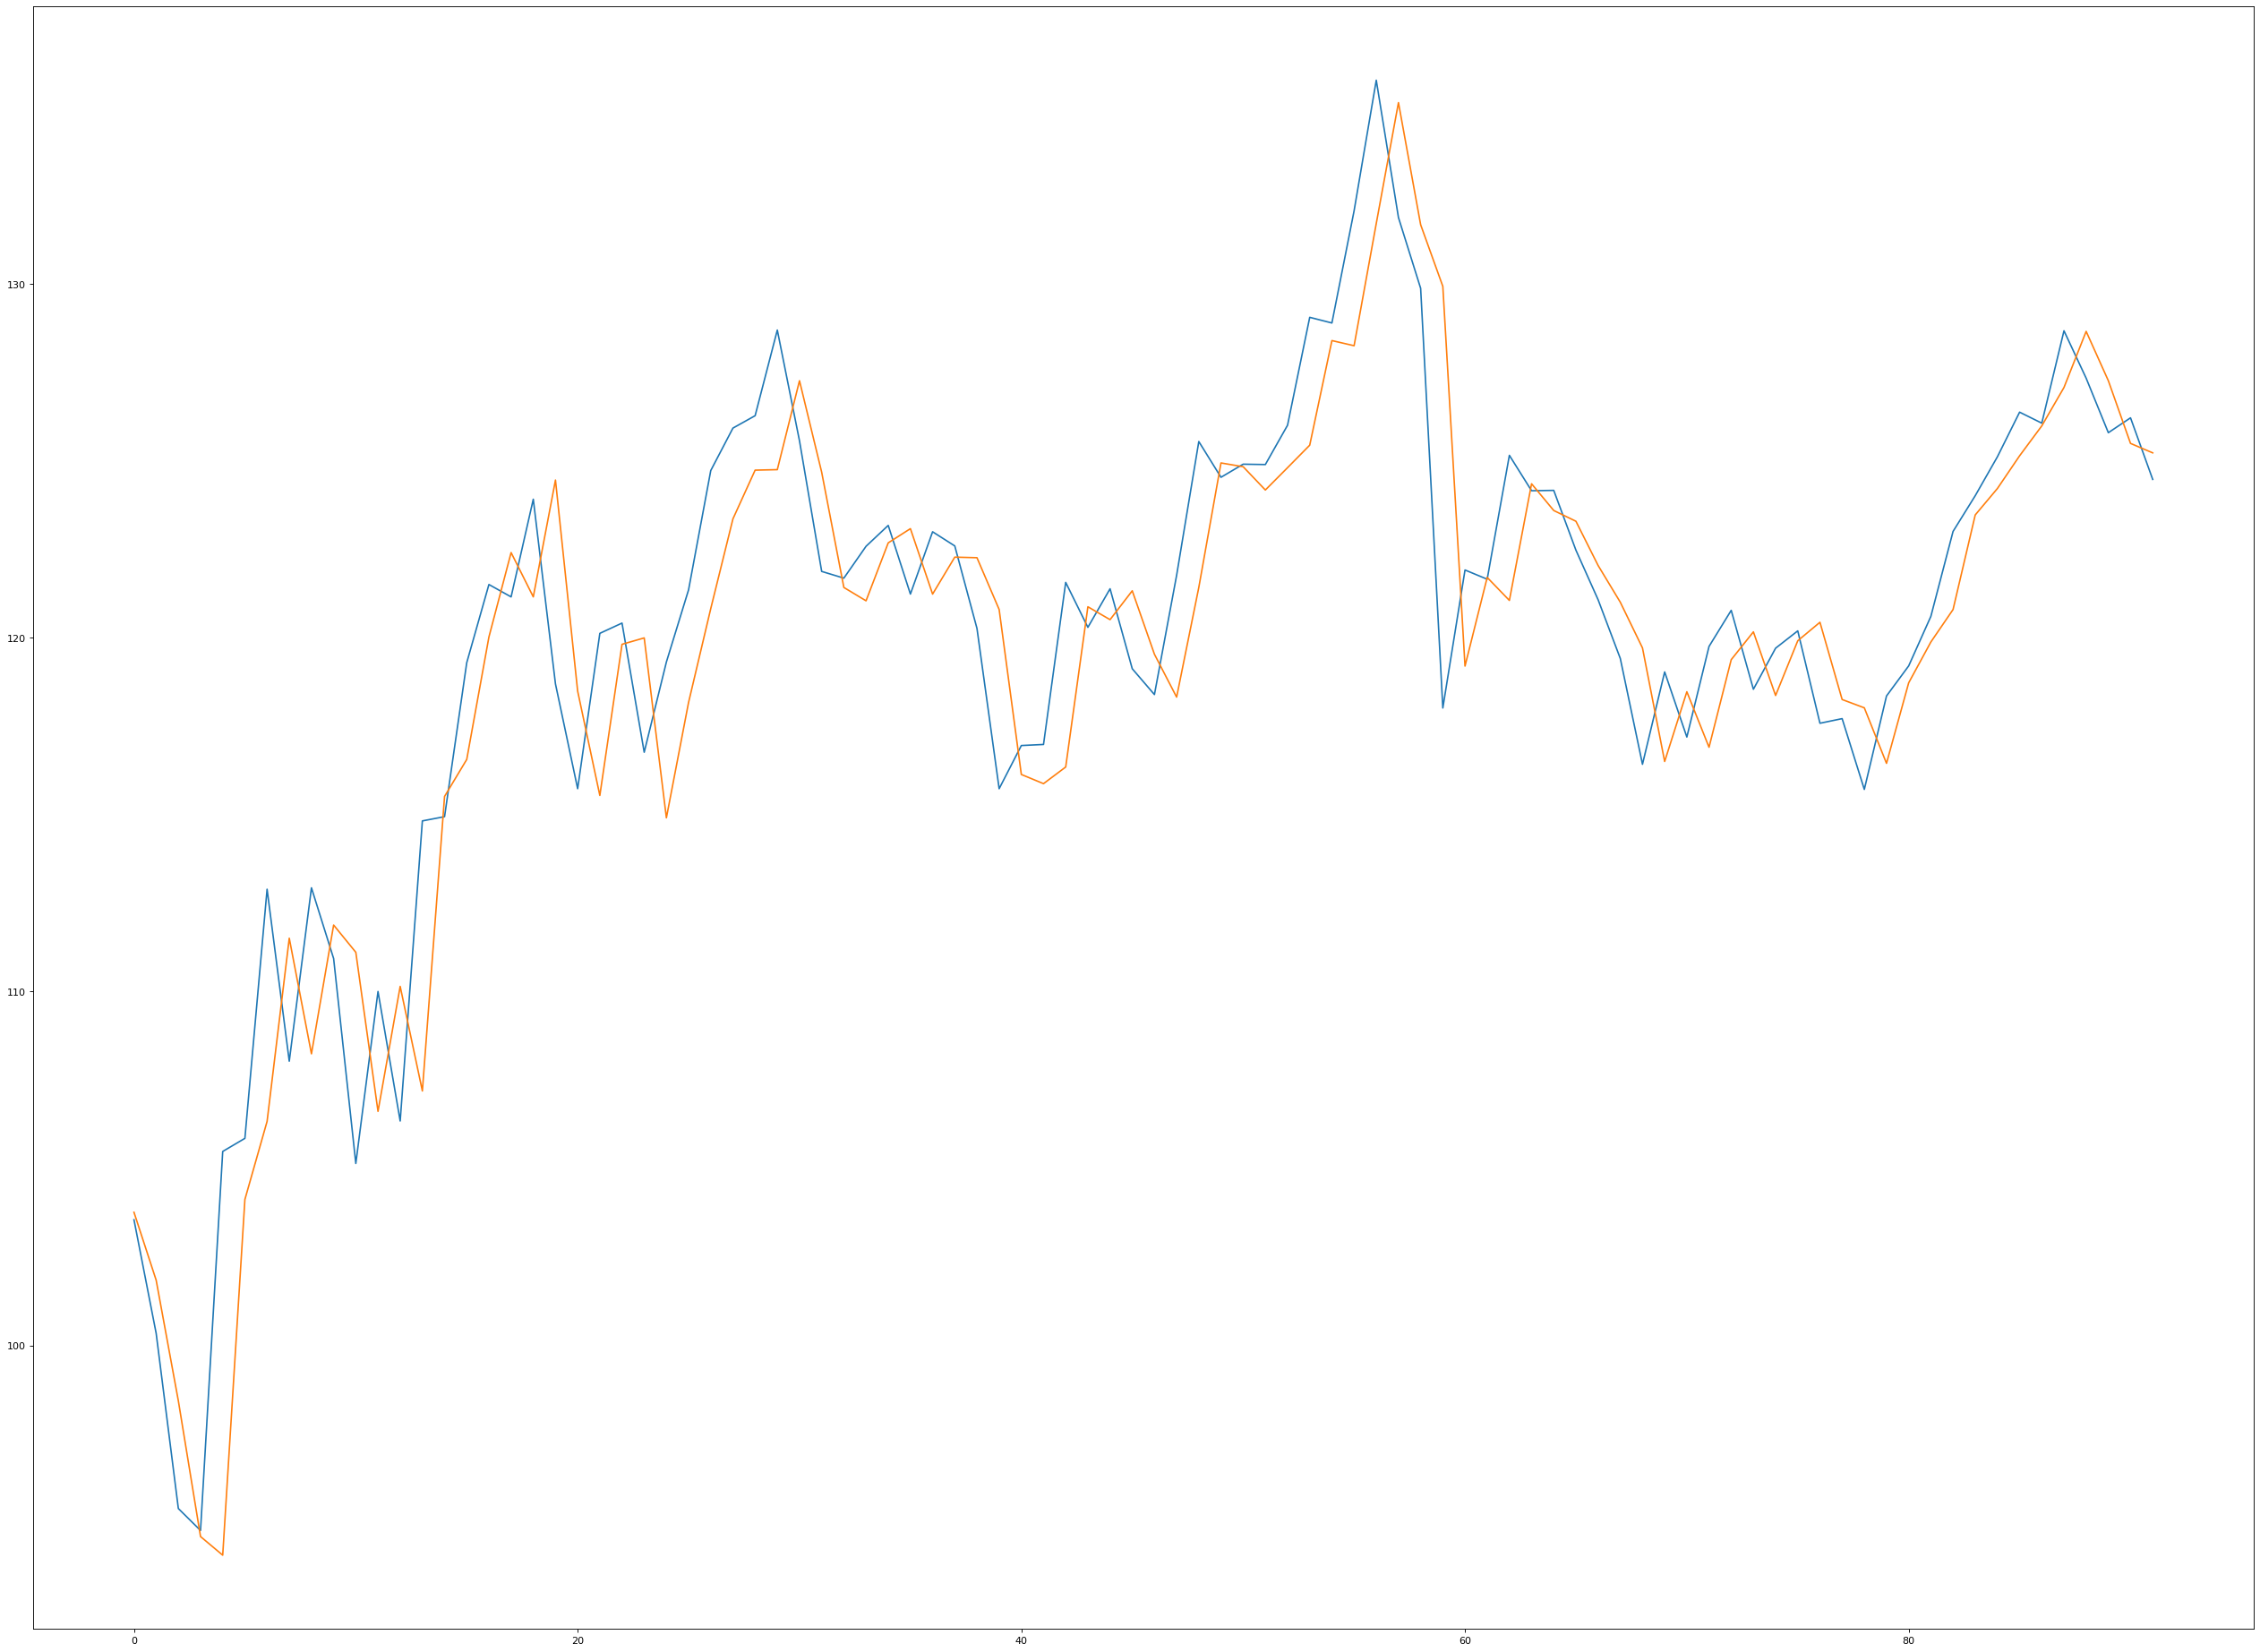

In [29]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:,3])
plt.plot(range(92), predicted_y_test[-92:,3])
plt.show()

##### Predictions over predictions for 30 days on

In [30]:
days = 30

subset = np.array([test_norm[-(backlook+days):-days]])
predicted = np.array(final_model[0].predict(subset))

for i in range(days):
    subset = np.append(subset[:,1:], np.array([[predicted[-1]]]), axis=1)
    predicted = np.append(predicted, final_model[0].predict(subset), axis=0)

In [31]:
predicted = normaliser.inverse_transform(predicted)

Here we can see the model behaviour when it uses its own predictions as input for 30 days onward

##### Open values

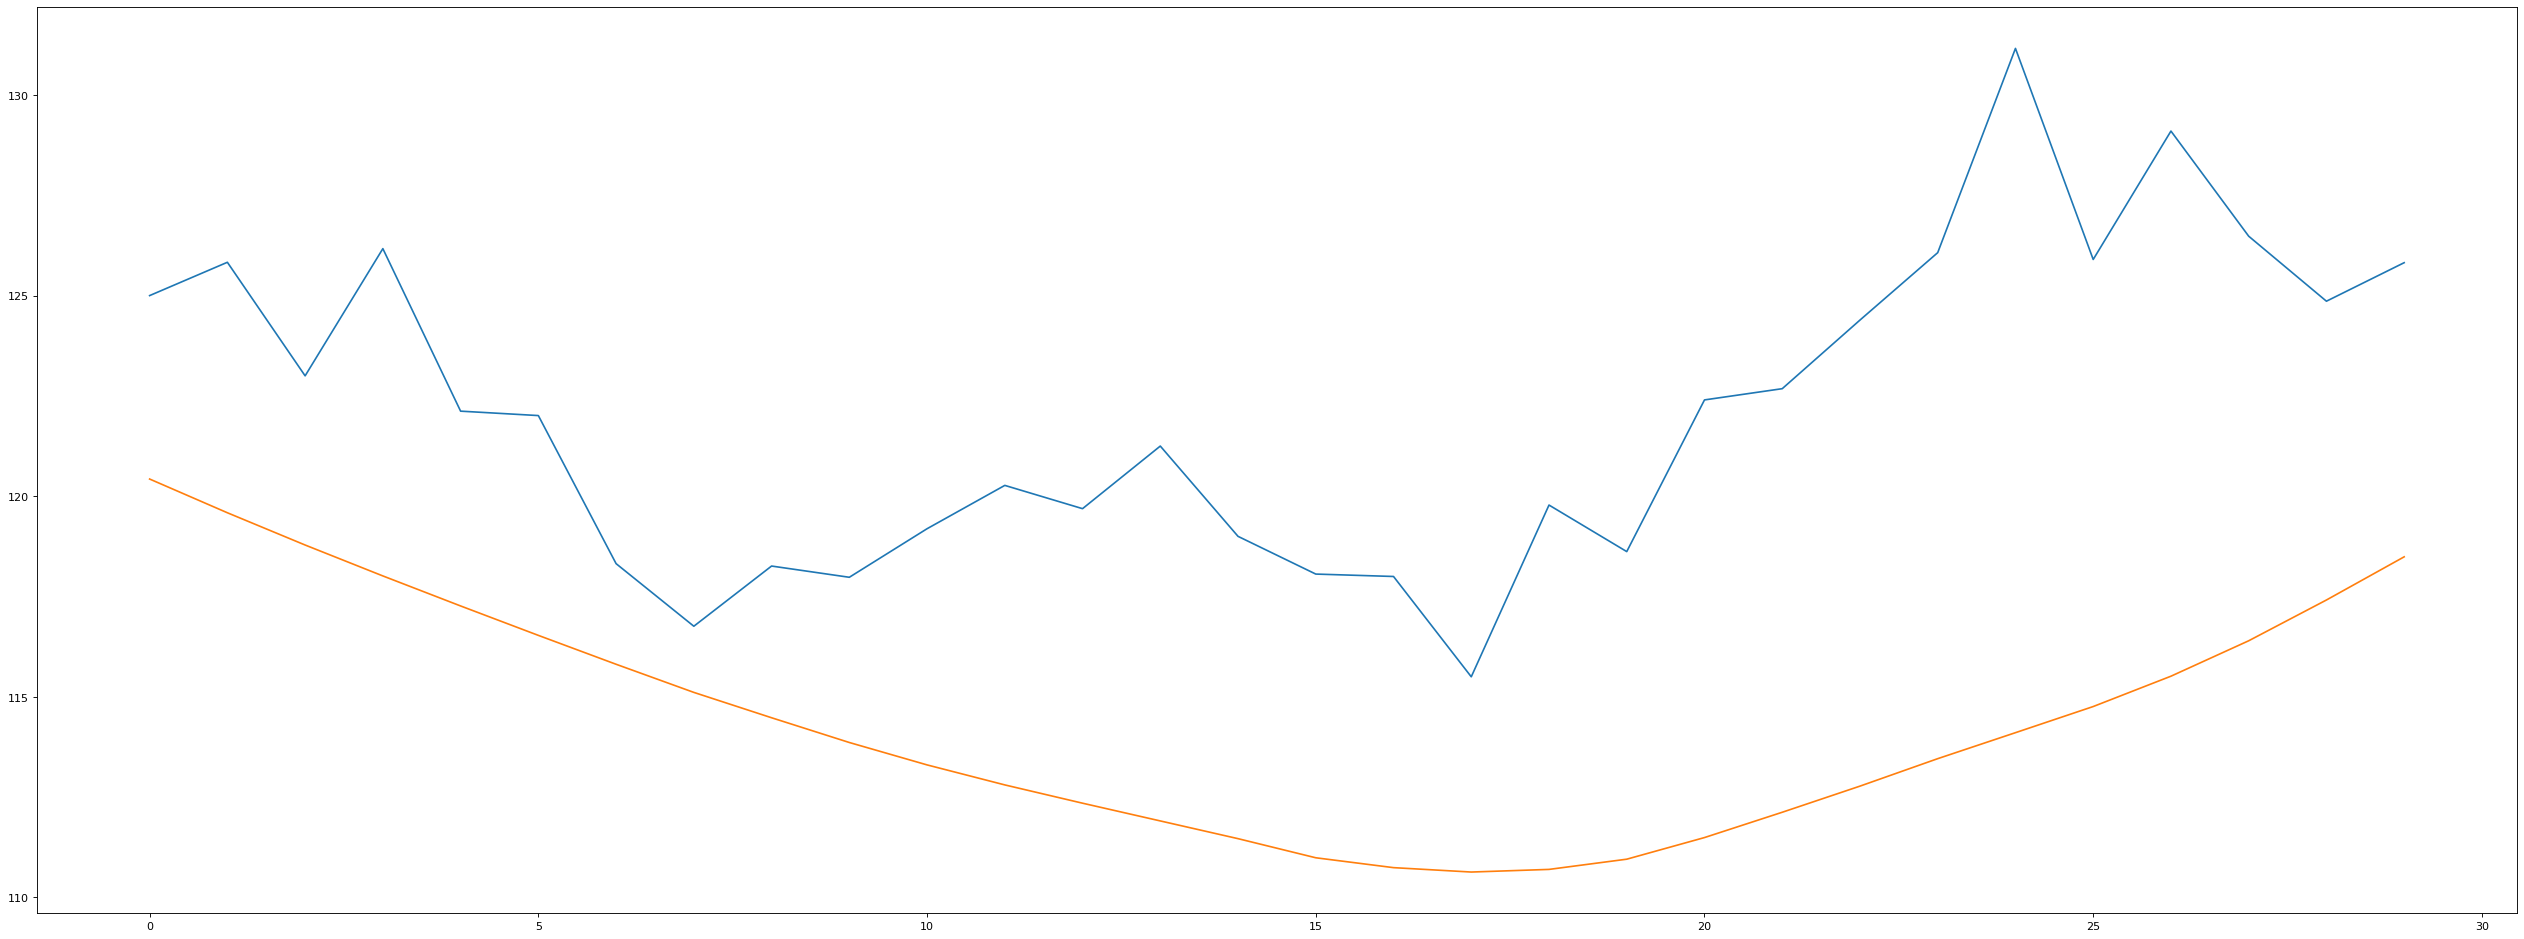

In [32]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,0])
plt.plot(range(days), predicted[-days:,0])
plt.show()

##### High values

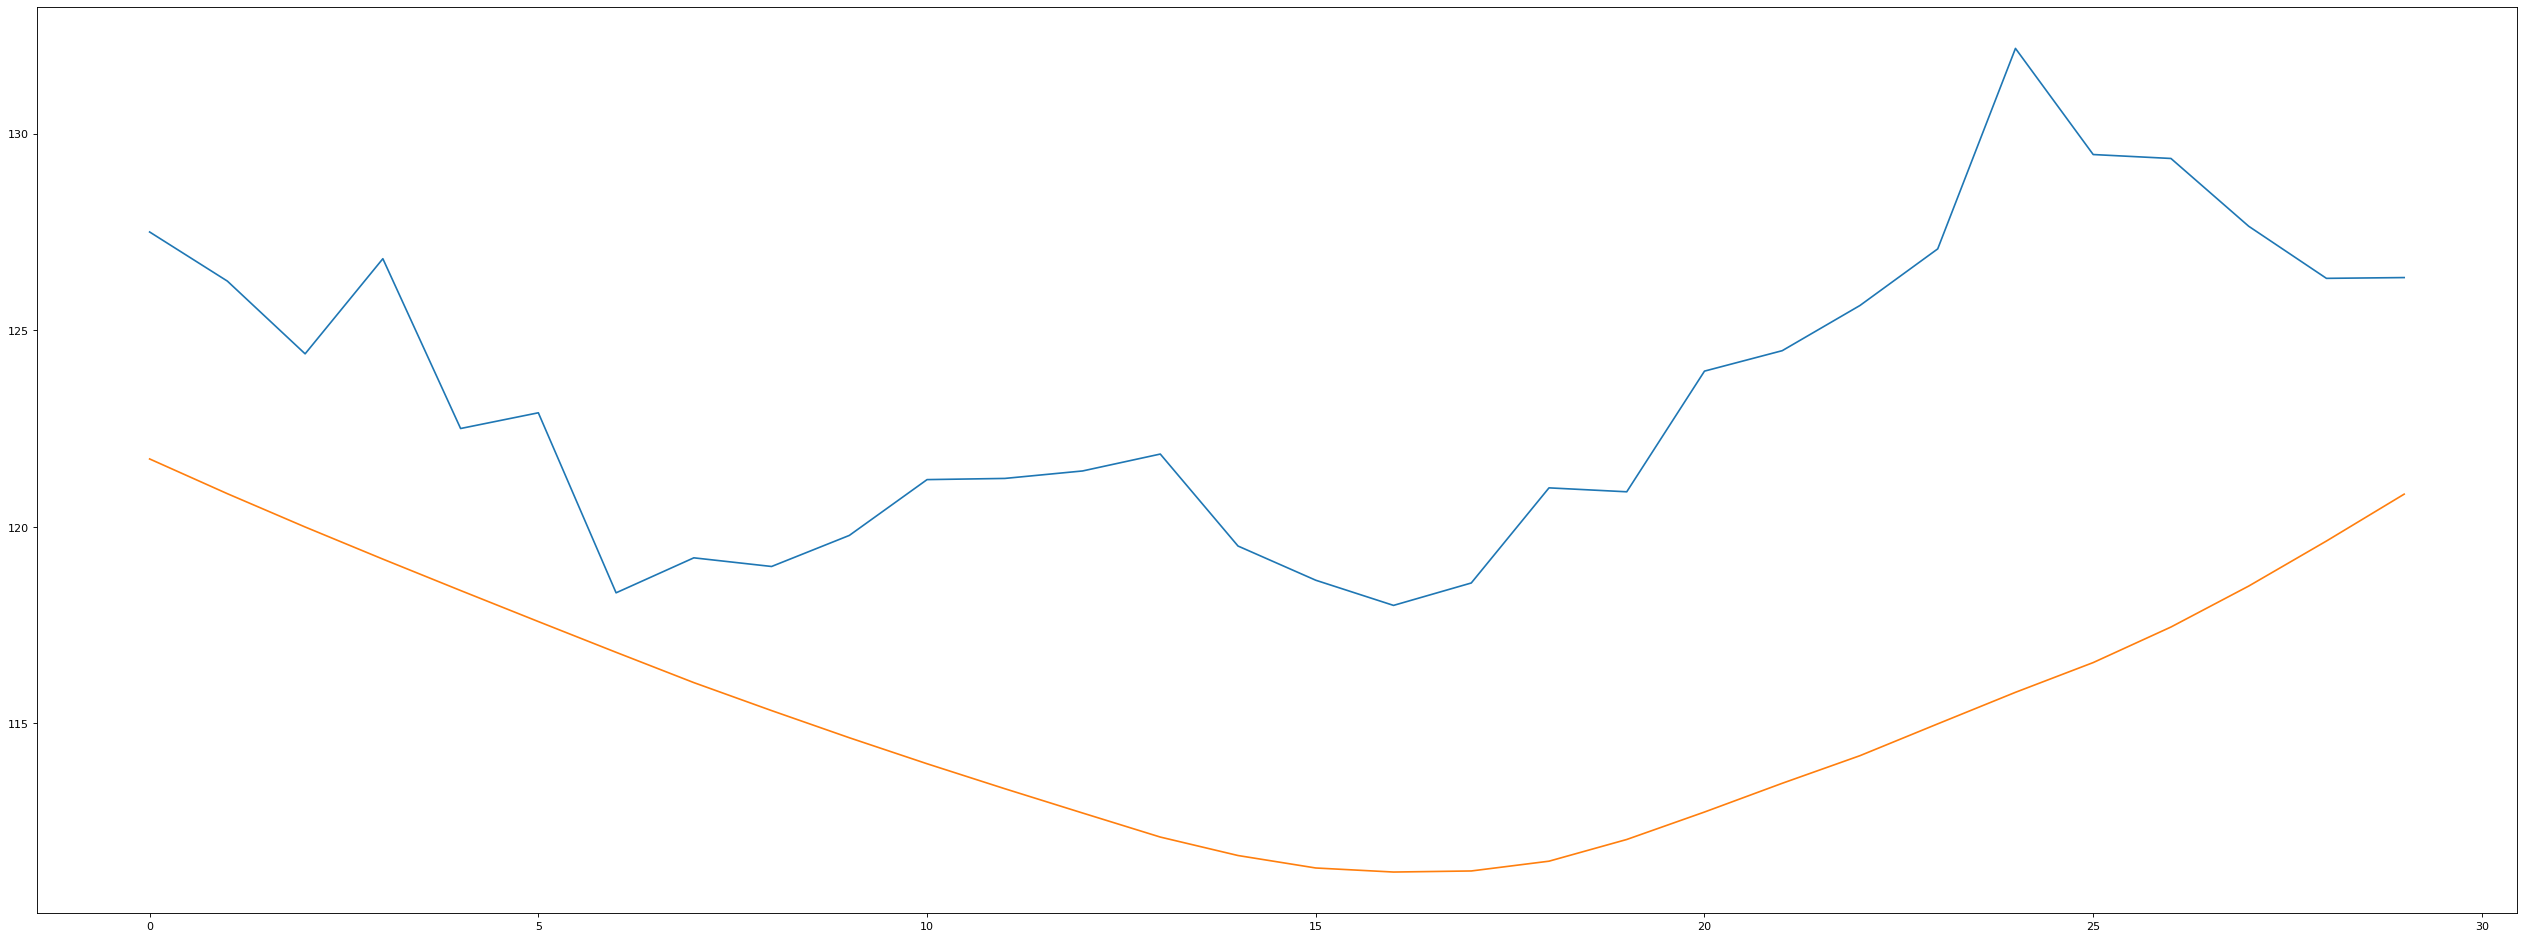

In [33]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,1])
plt.plot(range(days), predicted[-days:,1])
plt.show()

##### Low values

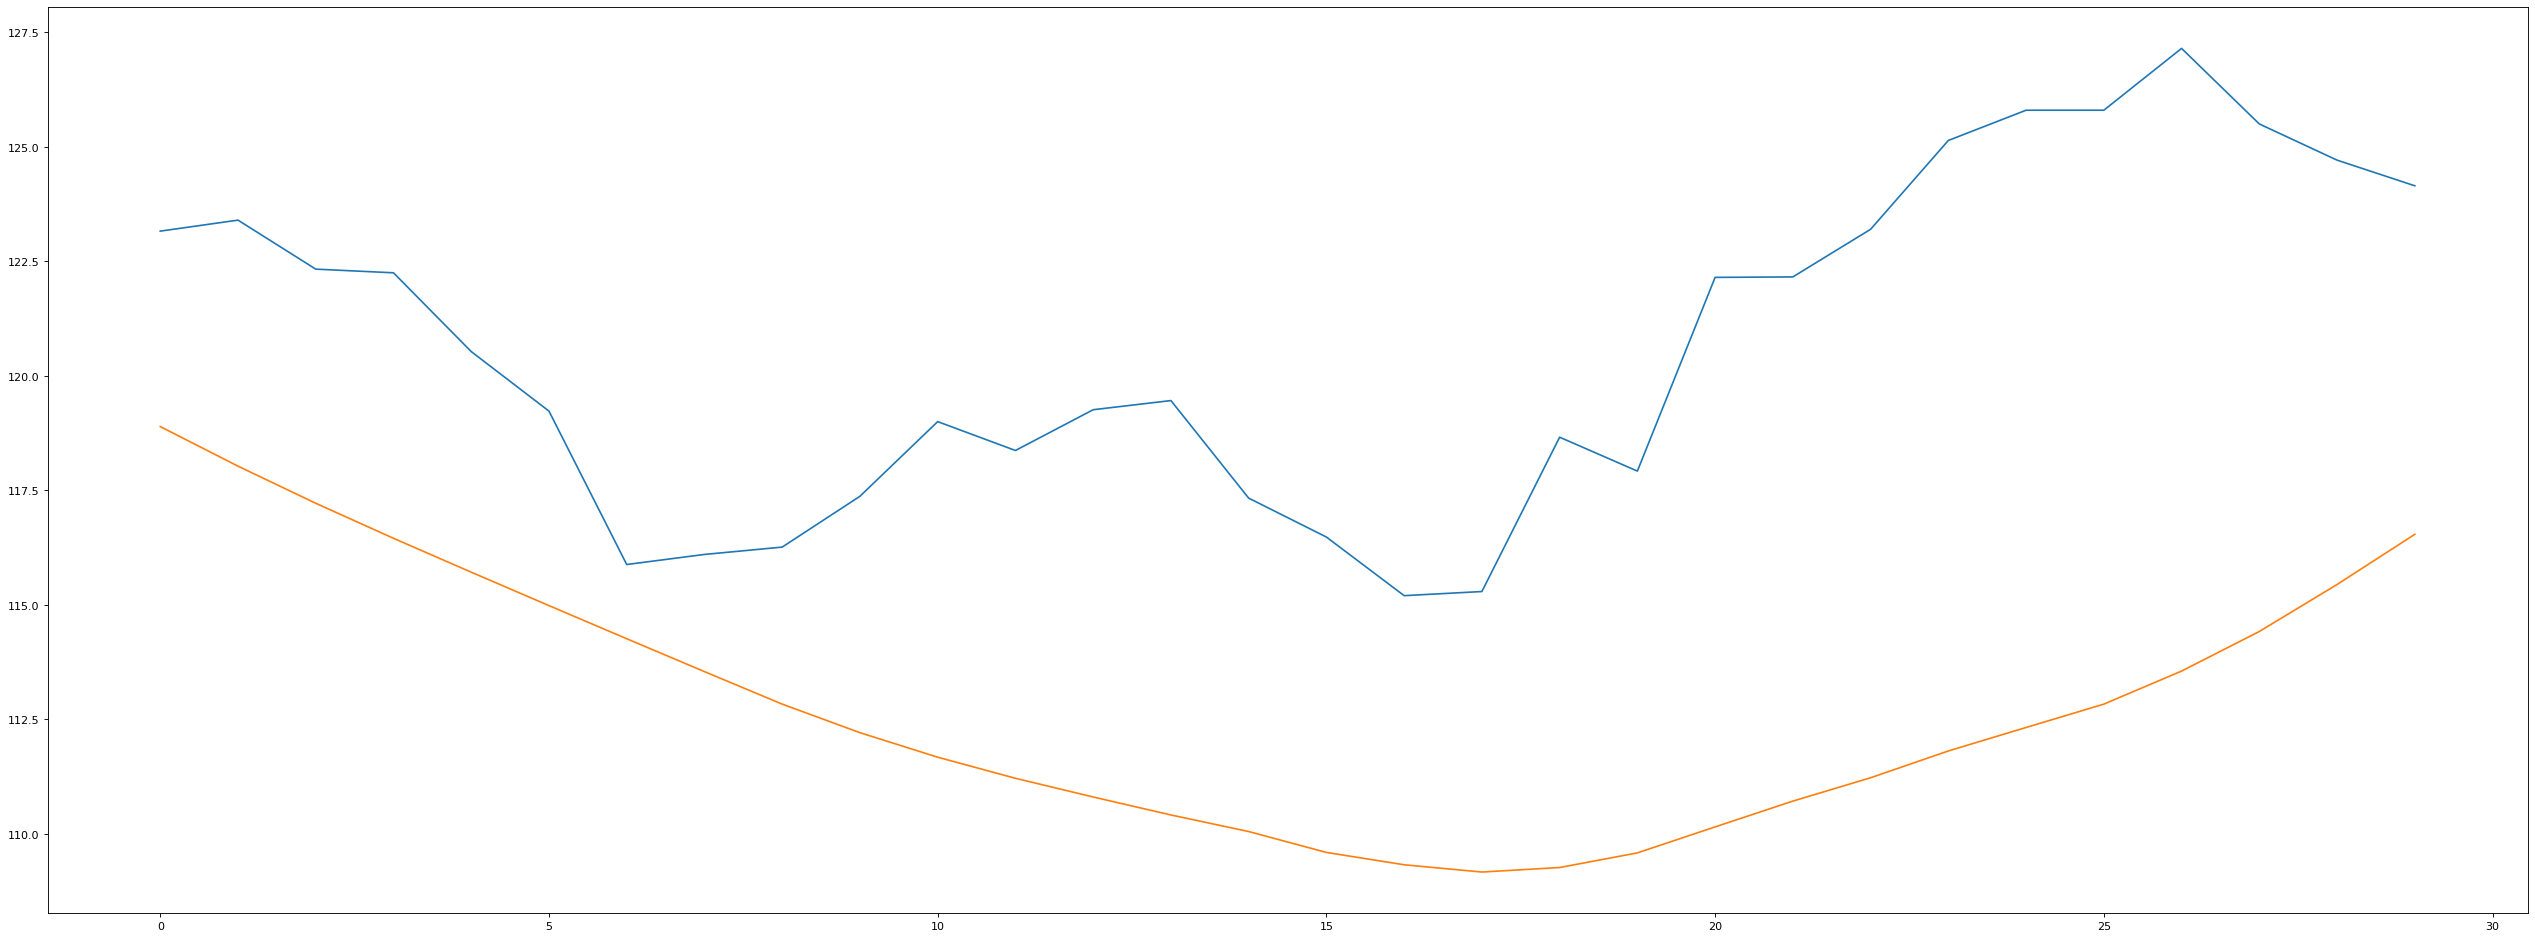

In [34]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,2])
plt.plot(range(days), predicted[-days:,2])
plt.show()

##### Close values

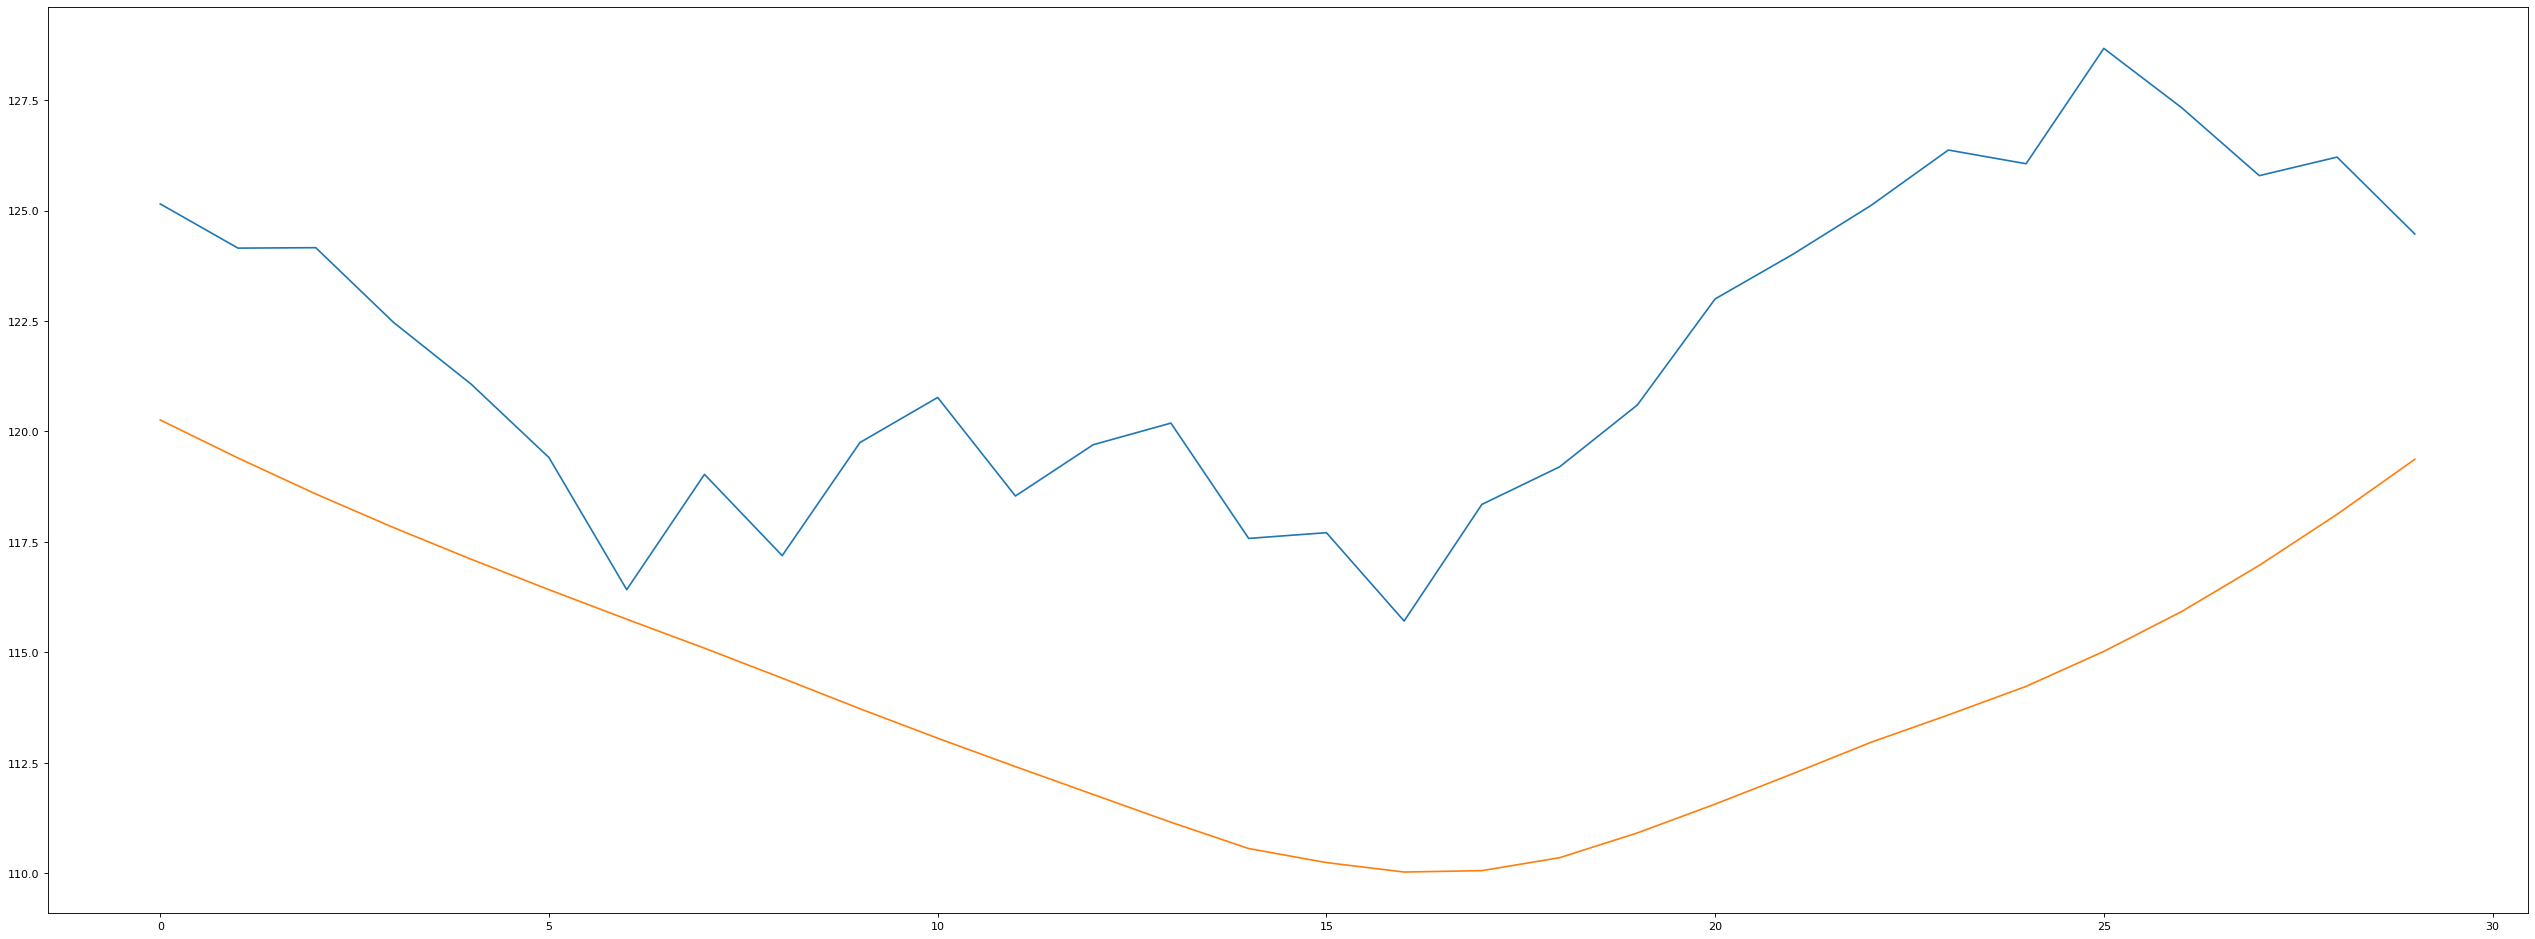

In [35]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,3])
plt.plot(range(days), predicted[-days:,3])
plt.show()

##### Volume values

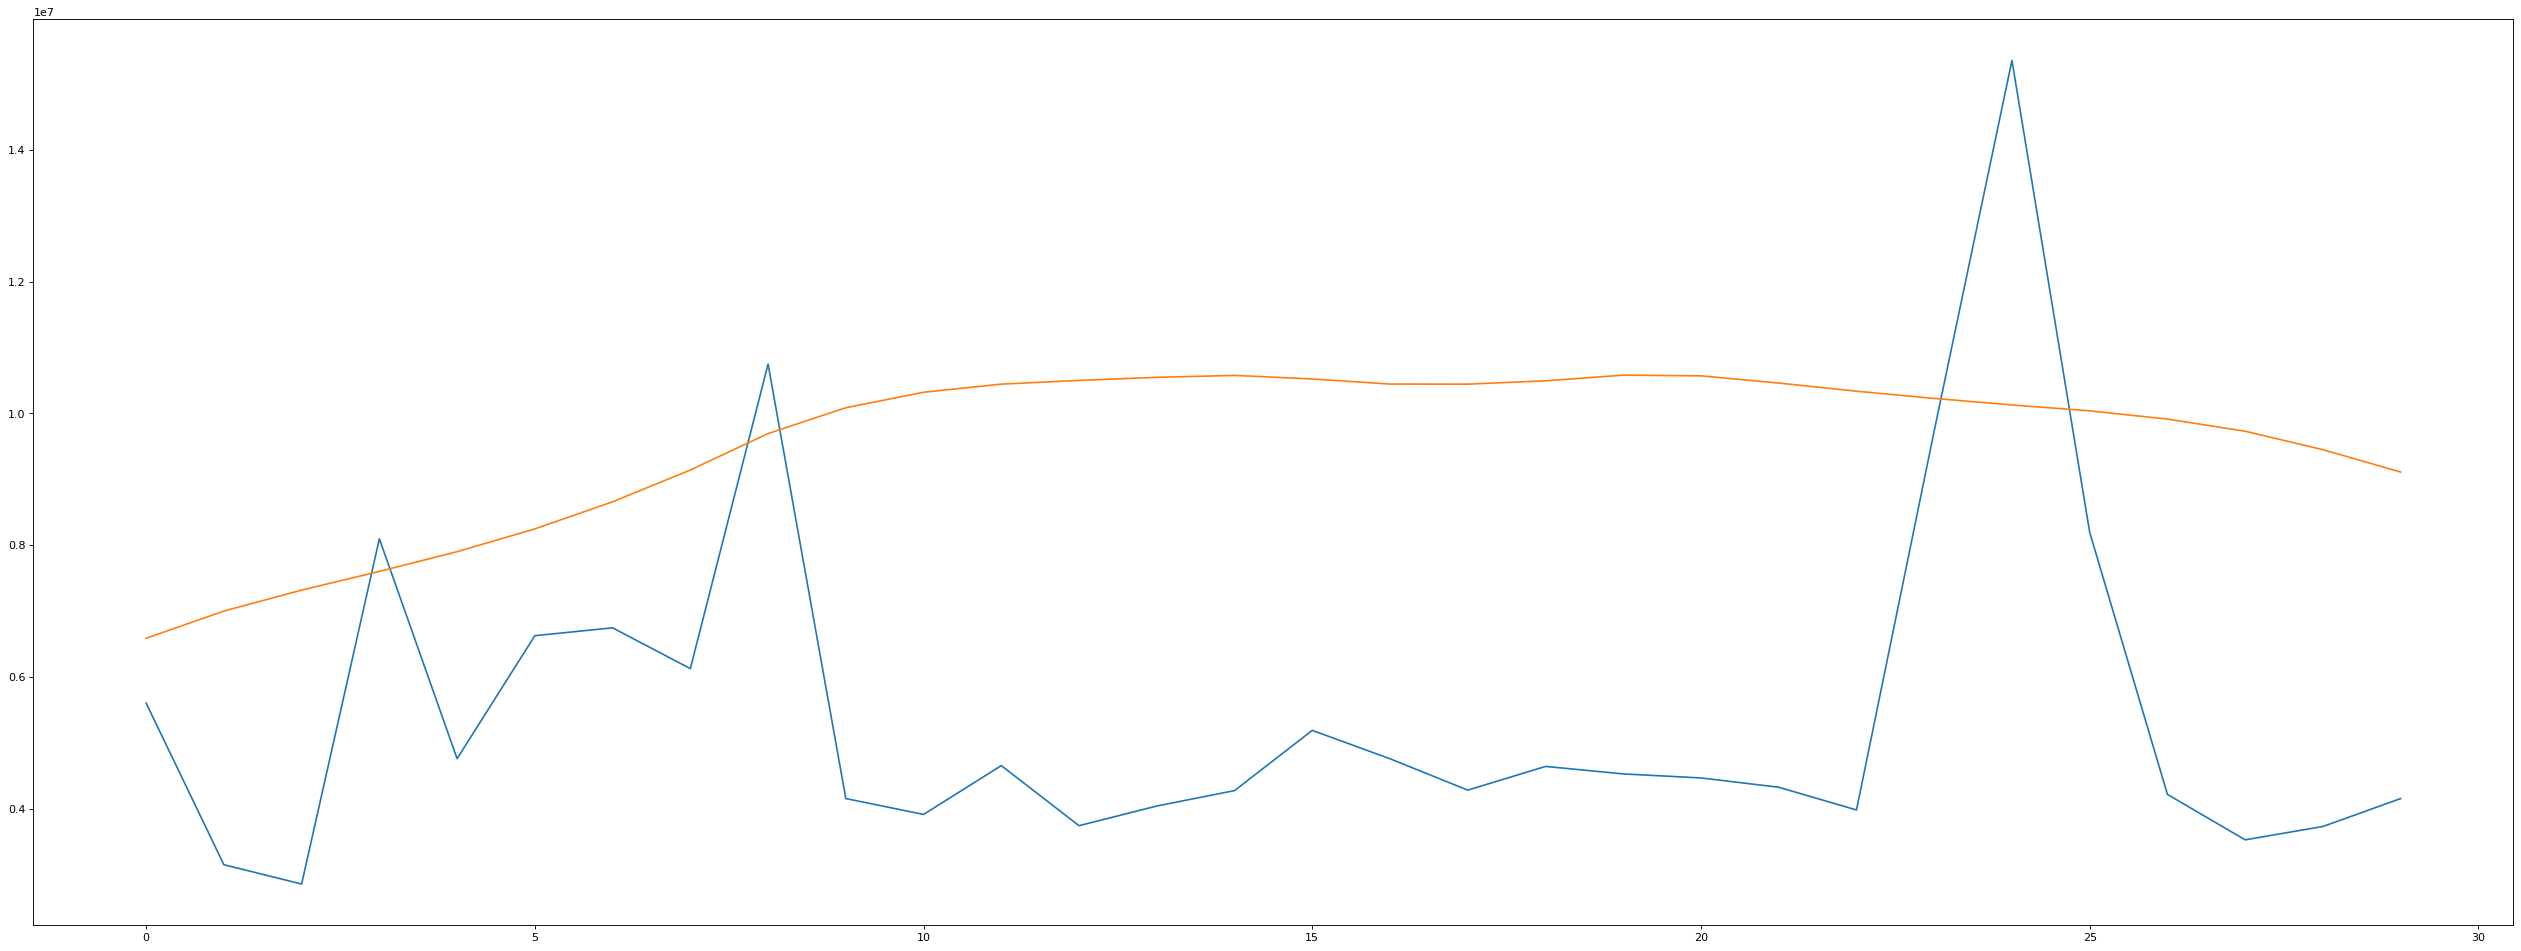

In [36]:
figure(num=None, figsize=(40, 15), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(days), true_y_test[-days:,4])
plt.plot(range(days), predicted[-days:,4])
plt.show()

##### It's not very accurate, but can be used to detect trends